In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-05 03:49:29,537] A new study created in memory with name: no-name-e5ff31b7-e458-490f-8a10-5c008d0b7fb2
[I 2025-06-05 03:53:00,666] Trial 0 finished with value: 0.0971013441681862 and parameters: {'lr': 0.006370784981907984, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.36474621837370735}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.15147754549980164, 0.10089372843503952, 0.09017982333898544, 0.07690838724374771, 0.06604723632335663]
Mean Cross Validation Accuracy:
0.0971013441681862
Standard Deviation of Cross Validation Accuracy:
0.02963502665314626


[I 2025-06-05 03:55:22,863] Trial 1 finished with value: 0.13202531933784484 and parameters: {'lr': 0.2504686575571378, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14723022138035288}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.1901097595691681, 0.10832657665014267, 0.12372848391532898, 0.10824859887361526, 0.12971317768096924]
Mean Cross Validation Accuracy:
0.13202531933784484
Standard Deviation of Cross Validation Accuracy:
0.030248796720094392


[I 2025-06-05 03:58:30,486] Trial 2 finished with value: 0.1010027676820755 and parameters: {'lr': 0.02918273812501055, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.19266973408689442}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.1509869247674942, 0.09366638213396072, 0.1068047359585762, 0.07713806629180908, 0.07641772925853729]
Mean Cross Validation Accuracy:
0.1010027676820755
Standard Deviation of Cross Validation Accuracy:
0.027422069342284708


[I 2025-06-05 04:00:24,022] Trial 3 finished with value: 0.11350497752428054 and parameters: {'lr': 0.30953271474480337, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11754516278474397}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.14250968396663666, 0.10691218078136444, 0.12146211415529251, 0.09793727844953537, 0.09870363026857376]
Mean Cross Validation Accuracy:
0.11350497752428054
Standard Deviation of Cross Validation Accuracy:
0.016789801208656953


[I 2025-06-05 04:04:03,069] Trial 4 finished with value: 0.2538682371377945 and parameters: {'lr': 0.41288977829726164, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4653025628009746}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.2673726975917816, 0.2198648601770401, 0.32970157265663147, 0.23701882362365723, 0.21538323163986206]
Mean Cross Validation Accuracy:
0.2538682371377945
Standard Deviation of Cross Validation Accuracy:
0.042081571398290836


[I 2025-06-05 04:07:22,897] Trial 5 finished with value: 0.10494962185621262 and parameters: {'lr': 0.0017417195954493594, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2919529441117375}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.12956558167934418, 0.10489451140165329, 0.11516204476356506, 0.10677973181009293, 0.06834623962640762]
Mean Cross Validation Accuracy:
0.10494962185621262
Standard Deviation of Cross Validation Accuracy:
0.02026523619363634


[I 2025-06-05 04:09:48,661] Trial 6 finished with value: 0.20531372725963593 and parameters: {'lr': 0.02969610204930449, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.22668173795821567}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.25211840867996216, 0.17430181801319122, 0.1718299388885498, 0.19883671402931213, 0.2294817566871643]
Mean Cross Validation Accuracy:
0.20531372725963593
Standard Deviation of Cross Validation Accuracy:
0.03130375743722566


[I 2025-06-05 04:12:24,656] Trial 7 finished with value: 0.11415810286998748 and parameters: {'lr': 0.004751433882278284, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3238441602866884}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.13894237577915192, 0.1071920171380043, 0.13403712213039398, 0.08459512889385223, 0.106023870408535]
Mean Cross Validation Accuracy:
0.11415810286998748
Standard Deviation of Cross Validation Accuracy:
0.019990483280138534


[I 2025-06-05 04:15:16,197] Trial 8 finished with value: 0.10150490850210189 and parameters: {'lr': 0.002206327024480379, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.41254473328419716}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.11430554836988449, 0.10180467367172241, 0.1342187076807022, 0.08345303684473038, 0.07374257594347]
Mean Cross Validation Accuracy:
0.10150490850210189
Standard Deviation of Cross Validation Accuracy:
0.021590535316706065


[I 2025-06-05 04:19:15,003] Trial 9 finished with value: 0.156626096367836 and parameters: {'lr': 0.014380895519152835, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.49791911302970826}. Best is trial 0 with value: 0.0971013441681862.


Cross Validation Accuracies:
[0.13060463964939117, 0.19053925573825836, 0.1383209079504013, 0.2497369647026062, 0.07392871379852295]
Mean Cross Validation Accuracy:
0.156626096367836
Standard Deviation of Cross Validation Accuracy:
0.05944878366644953


[I 2025-06-05 04:22:20,936] Trial 10 finished with value: 0.09684873968362809 and parameters: {'lr': 0.00783257588029929, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.36905969727075394}. Best is trial 10 with value: 0.09684873968362809.


Cross Validation Accuracies:
[0.14866092801094055, 0.09361891448497772, 0.0979648306965828, 0.0734468623995781, 0.07055216282606125]
Mean Cross Validation Accuracy:
0.09684873968362809
Standard Deviation of Cross Validation Accuracy:
0.028054725463178512


[I 2025-06-05 04:25:07,611] Trial 11 finished with value: 0.10264143347740173 and parameters: {'lr': 0.007607805796040274, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3727217693155937}. Best is trial 10 with value: 0.09684873968362809.


Cross Validation Accuracies:
[0.1443861722946167, 0.09713815897703171, 0.0909871980547905, 0.10091941058635712, 0.07977622747421265]
Mean Cross Validation Accuracy:
0.10264143347740173
Standard Deviation of Cross Validation Accuracy:
0.022065871661165436


[I 2025-06-05 04:28:01,235] Trial 12 finished with value: 0.11887097805738449 and parameters: {'lr': 0.11612999370986575, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.36763716540217045}. Best is trial 10 with value: 0.09684873968362809.


Cross Validation Accuracies:
[0.18180398643016815, 0.14105860888957977, 0.10593648254871368, 0.07927962392568588, 0.08627618849277496]
Mean Cross Validation Accuracy:
0.11887097805738449
Standard Deviation of Cross Validation Accuracy:
0.03807900026944303


[I 2025-06-05 04:30:41,620] Trial 13 finished with value: 0.31139140129089354 and parameters: {'lr': 0.001064258284145691, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2652789976051188}. Best is trial 10 with value: 0.09684873968362809.


Cross Validation Accuracies:
[0.27889755368232727, 0.2895442545413971, 0.39251768589019775, 0.2283211052417755, 0.36767640709877014]
Mean Cross Validation Accuracy:
0.31139140129089354
Standard Deviation of Cross Validation Accuracy:
0.06030472281815228


[I 2025-06-05 04:33:21,406] Trial 14 finished with value: 0.09647720158100129 and parameters: {'lr': 0.0058387012819801735, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.41734535478577667}. Best is trial 14 with value: 0.09647720158100129.


Cross Validation Accuracies:
[0.14378778636455536, 0.07922905683517456, 0.1092841774225235, 0.07972297817468643, 0.07036200910806656]
Mean Cross Validation Accuracy:
0.09647720158100129
Standard Deviation of Cross Validation Accuracy:
0.027064795730939176


[I 2025-06-05 04:36:28,158] Trial 15 finished with value: 0.13814858496189117 and parameters: {'lr': 0.10013766938982634, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.42082359176168066}. Best is trial 14 with value: 0.09647720158100129.


Cross Validation Accuracies:
[0.19338902831077576, 0.15029457211494446, 0.13617365062236786, 0.11635605990886688, 0.09452961385250092]
Mean Cross Validation Accuracy:
0.13814858496189117
Standard Deviation of Cross Validation Accuracy:
0.033407965336959396


[I 2025-06-05 04:39:02,064] Trial 16 finished with value: 0.31131168603897097 and parameters: {'lr': 0.0041051975278081744, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.42721313467325456}. Best is trial 14 with value: 0.09647720158100129.


Cross Validation Accuracies:
[0.3343314528465271, 0.3317984342575073, 0.3238270878791809, 0.30807971954345703, 0.2585217356681824]
Mean Cross Validation Accuracy:
0.31131168603897097
Standard Deviation of Cross Validation Accuracy:
0.027940924348504804


[I 2025-06-05 04:41:46,071] Trial 17 finished with value: 0.09758514761924744 and parameters: {'lr': 0.01534869852390003, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3248379928006805}. Best is trial 14 with value: 0.09647720158100129.


Cross Validation Accuracies:
[0.1435040384531021, 0.08691795915365219, 0.10114576667547226, 0.08364260196685791, 0.07271537184715271]
Mean Cross Validation Accuracy:
0.09758514761924744
Standard Deviation of Cross Validation Accuracy:
0.024689721664930848


[I 2025-06-05 04:44:14,899] Trial 18 finished with value: 0.13551610410213472 and parameters: {'lr': 0.07336497319975263, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.46399890599364596}. Best is trial 14 with value: 0.09647720158100129.


Cross Validation Accuracies:
[0.16855044662952423, 0.13159306347370148, 0.143165722489357, 0.11764130741357803, 0.11662998050451279]
Mean Cross Validation Accuracy:
0.13551610410213472
Standard Deviation of Cross Validation Accuracy:
0.019190459695699068


[I 2025-06-05 04:46:47,125] Trial 19 finished with value: 0.7818723440170288 and parameters: {'lr': 0.012567001157994978, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.37900394302247736}. Best is trial 14 with value: 0.09647720158100129.


Cross Validation Accuracies:
[0.721977710723877, 0.865014910697937, 0.7762267589569092, 0.7467823028564453, 0.7993600368499756]
Mean Cross Validation Accuracy:
0.7818723440170288
Standard Deviation of Cross Validation Accuracy:
0.04913055365361231


[I 2025-06-05 04:49:23,287] Trial 20 finished with value: 0.09631304740905762 and parameters: {'lr': 0.0031818800033721504, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32807834000843156}. Best is trial 20 with value: 0.09631304740905762.


Cross Validation Accuracies:
[0.14393651485443115, 0.08647038787603378, 0.09974124282598495, 0.08024467527866364, 0.07117241621017456]
Mean Cross Validation Accuracy:
0.09631304740905762
Standard Deviation of Cross Validation Accuracy:
0.025561177758543496


[I 2025-06-05 04:51:58,239] Trial 21 finished with value: 0.0965489849448204 and parameters: {'lr': 0.003150103357016068, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32362562726468425}. Best is trial 20 with value: 0.09631304740905762.


Cross Validation Accuracies:
[0.14339928328990936, 0.08701054006814957, 0.1009165570139885, 0.08047828078269958, 0.07094026356935501]
Mean Cross Validation Accuracy:
0.0965489849448204
Standard Deviation of Cross Validation Accuracy:
0.02537353824054161


[I 2025-06-05 04:54:33,992] Trial 22 finished with value: 0.09662196487188339 and parameters: {'lr': 0.0026813147747851676, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.25699945402380386}. Best is trial 20 with value: 0.09631304740905762.


Cross Validation Accuracies:
[0.14349523186683655, 0.08652836084365845, 0.10124055296182632, 0.08048805594444275, 0.0713576227426529]
Mean Cross Validation Accuracy:
0.09662196487188339
Standard Deviation of Cross Validation Accuracy:
0.02537284121853556


[I 2025-06-05 04:57:14,100] Trial 23 finished with value: 0.2126832962036133 and parameters: {'lr': 0.0010118780107464527, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.32597432707151847}. Best is trial 20 with value: 0.09631304740905762.


Cross Validation Accuracies:
[0.1336236596107483, 0.0829874724149704, 0.15562103688716888, 0.257655531167984, 0.4335287809371948]
Mean Cross Validation Accuracy:
0.2126832962036133
Standard Deviation of Cross Validation Accuracy:
0.12419562337667853


[I 2025-06-05 05:00:04,023] Trial 24 finished with value: 0.09625462740659714 and parameters: {'lr': 0.003296079511420624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.29242996320198134}. Best is trial 24 with value: 0.09625462740659714.


Cross Validation Accuracies:
[0.14313557744026184, 0.0854860320687294, 0.10105518251657486, 0.08029831200838089, 0.0712980329990387]
Mean Cross Validation Accuracy:
0.09625462740659714
Standard Deviation of Cross Validation Accuracy:
0.02535455405438785


[I 2025-06-05 05:03:15,592] Trial 25 finished with value: 0.09642901867628098 and parameters: {'lr': 0.0017647177529683247, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.208454192738632}. Best is trial 24 with value: 0.09625462740659714.


Cross Validation Accuracies:
[0.14352625608444214, 0.08635745942592621, 0.10069103538990021, 0.08023615181446075, 0.07133419066667557]
Mean Cross Validation Accuracy:
0.09642901867628098
Standard Deviation of Cross Validation Accuracy:
0.025415389801132632


[I 2025-06-05 05:06:12,052] Trial 26 finished with value: 0.12476685345172882 and parameters: {'lr': 0.9913930841223065, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1632656179498405}. Best is trial 24 with value: 0.09625462740659714.


Cross Validation Accuracies:
[0.16601191461086273, 0.11321524530649185, 0.10474672168493271, 0.13045868277549744, 0.10940170288085938]
Mean Cross Validation Accuracy:
0.12476685345172882
Standard Deviation of Cross Validation Accuracy:
0.022378048037476738


[I 2025-06-05 05:08:55,966] Trial 27 finished with value: 0.09668870270252228 and parameters: {'lr': 0.0017600709104612184, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23609069471721217}. Best is trial 24 with value: 0.09625462740659714.


Cross Validation Accuracies:
[0.14405609667301178, 0.08631756156682968, 0.10147279500961304, 0.08047747611999512, 0.07111958414316177]
Mean Cross Validation Accuracy:
0.09668870270252228
Standard Deviation of Cross Validation Accuracy:
0.02565424647276725


[I 2025-06-05 05:11:08,500] Trial 28 finished with value: 0.09605780243873596 and parameters: {'lr': 0.001537865097429513, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19701566594788494}. Best is trial 28 with value: 0.09605780243873596.


Cross Validation Accuracies:
[0.14466677606105804, 0.0855112373828888, 0.09360107034444809, 0.08180231600999832, 0.07470761239528656]
Mean Cross Validation Accuracy:
0.09605780243873596
Standard Deviation of Cross Validation Accuracy:
0.025056525664533993


[I 2025-06-05 05:13:30,032] Trial 29 finished with value: 0.09159111753106117 and parameters: {'lr': 0.008707498599127594, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2973306421204898}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1419389843940735, 0.08555158972740173, 0.08193739503622055, 0.08665114641189575, 0.06187647208571434]
Mean Cross Validation Accuracy:
0.09159111753106117
Standard Deviation of Cross Validation Accuracy:
0.02672804302733382


[I 2025-06-05 05:15:41,770] Trial 30 finished with value: 0.10024534612894058 and parameters: {'lr': 0.010498959240091307, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.28756673414530837}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1525287628173828, 0.0790223628282547, 0.1141258105635643, 0.07804720103740692, 0.07750259339809418]
Mean Cross Validation Accuracy:
0.10024534612894058
Standard Deviation of Cross Validation Accuracy:
0.029619684066514034


[I 2025-06-05 05:18:10,678] Trial 31 finished with value: 0.11886502057313919 and parameters: {'lr': 0.0040431350317570785, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26818773141964974}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.16008269786834717, 0.11991415172815323, 0.11037144809961319, 0.11194177716970444, 0.09201502799987793]
Mean Cross Validation Accuracy:
0.11886502057313919
Standard Deviation of Cross Validation Accuracy:
0.02254325518447924


[I 2025-06-05 05:20:31,754] Trial 32 finished with value: 0.11427031010389328 and parameters: {'lr': 0.0028668447650780572, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3433709180701963}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.17966046929359436, 0.1137007474899292, 0.1132560446858406, 0.07211912423372269, 0.09261516481637955]
Mean Cross Validation Accuracy:
0.11427031010389328
Standard Deviation of Cross Validation Accuracy:
0.03611895303701072


[I 2025-06-05 05:22:53,399] Trial 33 finished with value: 0.09456902891397476 and parameters: {'lr': 0.02143202535011636, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17721074089321673}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14352363348007202, 0.08680582791566849, 0.09054610878229141, 0.08158170431852341, 0.07038787007331848]
Mean Cross Validation Accuracy:
0.09456902891397476
Standard Deviation of Cross Validation Accuracy:
0.025402375980894475


[I 2025-06-05 05:25:09,801] Trial 34 finished with value: 0.09684391170740128 and parameters: {'lr': 0.020148489288813222, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16856963635885314}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14079435169696808, 0.08970721065998077, 0.10193069279193878, 0.07973542809486389, 0.07205187529325485]
Mean Cross Validation Accuracy:
0.09684391170740128
Standard Deviation of Cross Validation Accuracy:
0.0241486823657093


[I 2025-06-05 05:27:35,101] Trial 35 finished with value: 0.0999920055270195 and parameters: {'lr': 0.05019281828388377, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1133584371343862}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.11722132563591003, 0.09085165709257126, 0.15099245309829712, 0.08034711331129074, 0.06054747849702835]
Mean Cross Validation Accuracy:
0.0999920055270195
Standard Deviation of Cross Validation Accuracy:
0.03137908091762944


[I 2025-06-05 05:30:14,115] Trial 36 finished with value: 0.10043507814407349 and parameters: {'lr': 0.022302697490619666, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1400911133564704}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14250804483890533, 0.08239645510911942, 0.10086999833583832, 0.09321623295545578, 0.08318465948104858]
Mean Cross Validation Accuracy:
0.10043507814407349
Standard Deviation of Cross Validation Accuracy:
0.022115172497548723


[I 2025-06-05 05:32:36,166] Trial 37 finished with value: 0.10226943790912628 and parameters: {'lr': 0.008752475638268715, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19141495674994083}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14954937994480133, 0.08565043658018112, 0.10581514984369278, 0.09174145758152008, 0.0785907655954361]
Mean Cross Validation Accuracy:
0.10226943790912628
Standard Deviation of Cross Validation Accuracy:
0.025281115835772684


[I 2025-06-05 05:34:32,363] Trial 38 finished with value: 0.09488942623138427 and parameters: {'lr': 0.0012618412487826797, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22233115638626377}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.13780906796455383, 0.0854799672961235, 0.10262644290924072, 0.07880385965108871, 0.06972779333591461]
Mean Cross Validation Accuracy:
0.09488942623138427
Standard Deviation of Cross Validation Accuracy:
0.02400978222811244


[I 2025-06-05 05:36:57,696] Trial 39 finished with value: 0.09559492915868759 and parameters: {'lr': 0.04618234783820997, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19515862351468227}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14049173891544342, 0.089325912296772, 0.10544949024915695, 0.07726883143186569, 0.06543867290019989]
Mean Cross Validation Accuracy:
0.09559492915868759
Standard Deviation of Cross Validation Accuracy:
0.026066768585521705


[I 2025-06-05 05:39:05,809] Trial 40 finished with value: 0.09314332455396652 and parameters: {'lr': 0.04218006534563299, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2338904787232427}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.133916974067688, 0.08323410898447037, 0.09544367343187332, 0.08057349175214767, 0.07254837453365326]
Mean Cross Validation Accuracy:
0.09314332455396652
Standard Deviation of Cross Validation Accuracy:
0.02167084361918342


[I 2025-06-05 05:41:18,375] Trial 41 finished with value: 0.10242165327072143 and parameters: {'lr': 0.044627158913628416, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23294698067835234}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.15140999853610992, 0.09682533890008926, 0.094344861805439, 0.07889805734157562, 0.09063000977039337]
Mean Cross Validation Accuracy:
0.10242165327072143
Standard Deviation of Cross Validation Accuracy:
0.025253964792190824


[I 2025-06-05 05:43:57,436] Trial 42 finished with value: 0.09781554937362671 and parameters: {'lr': 0.15241507222559617, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21670087024622686}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1460658609867096, 0.09776455909013748, 0.09641709178686142, 0.07939033955335617, 0.06943989545106888]
Mean Cross Validation Accuracy:
0.09781554937362671
Standard Deviation of Cross Validation Accuracy:
0.026361778949245282


[I 2025-06-05 05:46:37,766] Trial 43 finished with value: 0.10352786630392075 and parameters: {'lr': 0.036693023426456736, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17907005761296385}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.175811305642128, 0.08245206624269485, 0.10245989263057709, 0.0828937292098999, 0.0740223377943039]
Mean Cross Validation Accuracy:
0.10352786630392075
Standard Deviation of Cross Validation Accuracy:
0.03732711975171583


[I 2025-06-05 05:48:59,677] Trial 44 finished with value: 0.10065267086029053 and parameters: {'lr': 0.06461813602119158, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13853090656739508}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.142744243144989, 0.08712456375360489, 0.1101769208908081, 0.08451317250728607, 0.07870445400476456]
Mean Cross Validation Accuracy:
0.10065267086029053
Standard Deviation of Cross Validation Accuracy:
0.02361198470334757


[I 2025-06-05 05:51:28,734] Trial 45 finished with value: 0.12120847553014755 and parameters: {'lr': 0.02458048579485678, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.24147056412575085}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.15926598012447357, 0.15019282698631287, 0.12066992372274399, 0.0990830808877945, 0.07683056592941284]
Mean Cross Validation Accuracy:
0.12120847553014755
Standard Deviation of Cross Validation Accuracy:
0.03081456886585228


[I 2025-06-05 05:53:55,014] Trial 46 finished with value: 0.09802408218383789 and parameters: {'lr': 0.17573691891584914, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1544788072633074}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14462178945541382, 0.08585211634635925, 0.11070780456066132, 0.08168041706085205, 0.06725828349590302]
Mean Cross Validation Accuracy:
0.09802408218383789
Standard Deviation of Cross Validation Accuracy:
0.027180984703308295


[I 2025-06-05 05:56:06,933] Trial 47 finished with value: 0.09867841154336929 and parameters: {'lr': 0.03460206740083285, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2533563789202945}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1458740532398224, 0.08473552018404007, 0.09571359306573868, 0.08646753430366516, 0.08060135692358017]
Mean Cross Validation Accuracy:
0.09867841154336929
Standard Deviation of Cross Validation Accuracy:
0.024110198630012583


[I 2025-06-05 05:58:18,146] Trial 48 finished with value: 0.10111390799283981 and parameters: {'lr': 0.05526704699830026, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21327593446144819}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1445390284061432, 0.0877532809972763, 0.10398149490356445, 0.07606557011604309, 0.09323016554117203]
Mean Cross Validation Accuracy:
0.10111390799283981
Standard Deviation of Cross Validation Accuracy:
0.023503374722577332


[I 2025-06-05 06:00:37,978] Trial 49 finished with value: 0.13095770925283431 and parameters: {'lr': 0.018265589310463525, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2765411759476154}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.138633131980896, 0.17011235654354095, 0.15563057363033295, 0.09120369702577591, 0.0992087870836258]
Mean Cross Validation Accuracy:
0.13095770925283431
Standard Deviation of Cross Validation Accuracy:
0.03094874570046449


[I 2025-06-05 06:03:10,991] Trial 50 finished with value: 0.0969013199210167 and parameters: {'lr': 0.09282656765810601, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18393160347180934}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14517104625701904, 0.08722414821386337, 0.10446547716856003, 0.07970836758613586, 0.06793756037950516]
Mean Cross Validation Accuracy:
0.0969013199210167
Standard Deviation of Cross Validation Accuracy:
0.026889877591524416


[I 2025-06-05 06:05:23,395] Trial 51 finished with value: 0.1111057698726654 and parameters: {'lr': 0.005573920287929777, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20026573042176948}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.13435418903827667, 0.14216050505638123, 0.10132647305727005, 0.09678338468074799, 0.08090429753065109]
Mean Cross Validation Accuracy:
0.1111057698726654
Standard Deviation of Cross Validation Accuracy:
0.02331428689214144


[I 2025-06-05 06:07:38,338] Trial 52 finished with value: 0.09836589395999909 and parameters: {'lr': 0.0012902708546601704, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10004124623639993}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14432580769062042, 0.08842451870441437, 0.10211893916130066, 0.08359983563423157, 0.0733603686094284]
Mean Cross Validation Accuracy:
0.09836589395999909
Standard Deviation of Cross Validation Accuracy:
0.02477314165349047


[I 2025-06-05 06:09:54,537] Trial 53 finished with value: 0.1004606693983078 and parameters: {'lr': 0.02752728147411638, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22088328467782697}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14348359405994415, 0.08682385087013245, 0.116566501557827, 0.08446799963712692, 0.07096140086650848]
Mean Cross Validation Accuracy:
0.1004606693983078
Standard Deviation of Cross Validation Accuracy:
0.026162205662226653


[I 2025-06-05 06:12:43,262] Trial 54 finished with value: 0.1041317418217659 and parameters: {'lr': 0.0013848268902880425, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1966247227373766}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.13840705156326294, 0.11002456396818161, 0.10902941972017288, 0.08025246113538742, 0.08294521272182465]
Mean Cross Validation Accuracy:
0.1041317418217659
Standard Deviation of Cross Validation Accuracy:
0.02122544944599713


[I 2025-06-05 06:15:16,609] Trial 55 finished with value: 0.09424363896250725 and parameters: {'lr': 0.03908173523292941, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18001384831063055}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.15115301311016083, 0.08519167453050613, 0.10137065500020981, 0.06176137551665306, 0.07174147665500641]
Mean Cross Validation Accuracy:
0.09424363896250725
Standard Deviation of Cross Validation Accuracy:
0.03140972470632779


[I 2025-06-05 06:17:53,474] Trial 56 finished with value: 0.11208764761686325 and parameters: {'lr': 0.04224016432493133, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13167163028777956}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1620960682630539, 0.09185827523469925, 0.1278873234987259, 0.10225759446620941, 0.07633897662162781]
Mean Cross Validation Accuracy:
0.11208764761686325
Standard Deviation of Cross Validation Accuracy:
0.030114105742474858


[I 2025-06-05 06:21:15,773] Trial 57 finished with value: 0.10209371224045753 and parameters: {'lr': 0.0776442696131951, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2456895791784852}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.17230704426765442, 0.1030254065990448, 0.09137597680091858, 0.08191551268100739, 0.06184462085366249]
Mean Cross Validation Accuracy:
0.10209371224045753
Standard Deviation of Cross Validation Accuracy:
0.03761063412550961


[I 2025-06-05 06:23:42,142] Trial 58 finished with value: 0.1002593994140625 and parameters: {'lr': 0.017710553956593895, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3050303290773564}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.16122902929782867, 0.08678656071424484, 0.10782287269830704, 0.08016403019428253, 0.06529450416564941]
Mean Cross Validation Accuracy:
0.1002593994140625
Standard Deviation of Cross Validation Accuracy:
0.033413730838468186


[I 2025-06-05 06:25:56,622] Trial 59 finished with value: 0.1026075541973114 and parameters: {'lr': 0.01230494297329372, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16766619527333376}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14911696314811707, 0.08312279731035233, 0.10973473638296127, 0.08584862947463989, 0.08521464467048645]
Mean Cross Validation Accuracy:
0.1026075541973114
Standard Deviation of Cross Validation Accuracy:
0.025206953237045984


[I 2025-06-05 06:28:07,255] Trial 60 finished with value: 0.09953907281160354 and parameters: {'lr': 0.03110530321891762, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18038060650010726}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1365514099597931, 0.09735370427370071, 0.10747992247343063, 0.08136221021413803, 0.07494811713695526]
Mean Cross Validation Accuracy:
0.09953907281160354
Standard Deviation of Cross Validation Accuracy:
0.02178467105580942


[I 2025-06-05 06:30:20,978] Trial 61 finished with value: 0.15338608920574187 and parameters: {'lr': 0.06153602369804225, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1967128231152423}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.207166388630867, 0.10655473172664642, 0.19623684883117676, 0.16524241864681244, 0.09173005819320679]
Mean Cross Validation Accuracy:
0.15338608920574187
Standard Deviation of Cross Validation Accuracy:
0.04661270847762792


[I 2025-06-05 06:32:48,348] Trial 62 finished with value: 0.09829187840223312 and parameters: {'lr': 0.006814884132762757, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15344513899875117}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1530849039554596, 0.09512888640165329, 0.10567472130060196, 0.06775354593992233, 0.06981733441352844]
Mean Cross Validation Accuracy:
0.09829187840223312
Standard Deviation of Cross Validation Accuracy:
0.031016692092734707


[I 2025-06-05 06:35:17,158] Trial 63 finished with value: 0.09722425788640976 and parameters: {'lr': 0.0014076539450310287, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20970105063676375}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14612792432308197, 0.08745453506708145, 0.099624864757061, 0.07723385095596313, 0.07568011432886124]
Mean Cross Validation Accuracy:
0.09722425788640976
Standard Deviation of Cross Validation Accuracy:
0.025909633263079317


[I 2025-06-05 06:37:26,216] Trial 64 finished with value: 0.10205456763505935 and parameters: {'lr': 0.04022007402010981, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2265928880696702}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.146230086684227, 0.08590627461671829, 0.10342412441968918, 0.08591925352811813, 0.08879309892654419]
Mean Cross Validation Accuracy:
0.10205456763505935
Standard Deviation of Cross Validation Accuracy:
0.023023181578975937


[I 2025-06-05 06:39:53,458] Trial 65 finished with value: 1.7862505793571473 and parameters: {'lr': 0.1354977759920528, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17453648415752882}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[1.848212718963623, 3.2493813037872314, 1.6480118036270142, 0.8305358290672302, 1.3551112413406372]
Mean Cross Validation Accuracy:
1.7862505793571473
Standard Deviation of Cross Validation Accuracy:
0.8078332247856997


[I 2025-06-05 06:42:30,972] Trial 66 finished with value: 1.1720819115638732 and parameters: {'lr': 0.3467036135248987, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3956306544276452}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.8762902021408081, 1.776949405670166, 1.7104485034942627, 0.9070396423339844, 0.5896818041801453]
Mean Cross Validation Accuracy:
1.1720819115638732
Standard Deviation of Cross Validation Accuracy:
0.48013191888390305


[I 2025-06-05 06:44:52,170] Trial 67 finished with value: 0.11264639347791672 and parameters: {'lr': 0.0023161863334891933, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.12583059869562468}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14929050207138062, 0.09654200822114944, 0.0884375274181366, 0.06939060986042023, 0.1595713198184967]
Mean Cross Validation Accuracy:
0.11264639347791672
Standard Deviation of Cross Validation Accuracy:
0.035387067251867216


[I 2025-06-05 06:47:02,934] Trial 68 finished with value: 0.09619523882865906 and parameters: {'lr': 0.002145905369416169, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15815062851525016}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14744722843170166, 0.07449299097061157, 0.10271421074867249, 0.08534776419401169, 0.07097399979829788]
Mean Cross Validation Accuracy:
0.09619523882865906
Standard Deviation of Cross Validation Accuracy:
0.027907094436477507


[I 2025-06-05 06:49:27,219] Trial 69 finished with value: 0.09593219757080078 and parameters: {'lr': 0.010334163610133052, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3052507983614947}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.13398441672325134, 0.08796703070402145, 0.09449943155050278, 0.08805041015148163, 0.0751596987247467]
Mean Cross Validation Accuracy:
0.09593219757080078
Standard Deviation of Cross Validation Accuracy:
0.020035405488002186


[I 2025-06-05 06:51:35,297] Trial 70 finished with value: 0.10584449619054795 and parameters: {'lr': 0.00995024436333642, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.343013268539796}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.15192429721355438, 0.1000211089849472, 0.10346301645040512, 0.08839046955108643, 0.08542358875274658]
Mean Cross Validation Accuracy:
0.10584449619054795
Standard Deviation of Cross Validation Accuracy:
0.024019108447788873


[I 2025-06-05 06:53:47,829] Trial 71 finished with value: 0.09702632129192353 and parameters: {'lr': 0.01481880887572235, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2711215438519202}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14438661932945251, 0.08648543059825897, 0.10960894823074341, 0.07564332336187363, 0.06900728493928909]
Mean Cross Validation Accuracy:
0.09702632129192353
Standard Deviation of Cross Validation Accuracy:
0.027403392877918018


[I 2025-06-05 06:56:04,191] Trial 72 finished with value: 0.10497751533985138 and parameters: {'lr': 0.004566986246889592, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31034017472127606}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.16682934761047363, 0.09001196175813675, 0.09463407099246979, 0.087503582239151, 0.08590861409902573]
Mean Cross Validation Accuracy:
0.10497751533985138
Standard Deviation of Cross Validation Accuracy:
0.03106626827524624


[I 2025-06-05 06:58:20,131] Trial 73 finished with value: 0.09979640990495682 and parameters: {'lr': 0.02451655576847001, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2570426952221214}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14977718889713287, 0.08851709961891174, 0.09991557896137238, 0.07514530420303345, 0.08562687784433365]
Mean Cross Validation Accuracy:
0.09979640990495682
Standard Deviation of Cross Validation Accuracy:
0.026205983902925924


[I 2025-06-05 07:00:31,586] Trial 74 finished with value: 0.09483269602060318 and parameters: {'lr': 0.029545258720383258, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20396146622296324}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14206261932849884, 0.08523692190647125, 0.10013417154550552, 0.07494010776281357, 0.07178965955972672]
Mean Cross Validation Accuracy:
0.09483269602060318
Standard Deviation of Cross Validation Accuracy:
0.025602916928317055


[I 2025-06-05 07:02:34,286] Trial 75 finished with value: 0.09814383238554 and parameters: {'lr': 0.029600482090207526, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2894446327394259}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14028765261173248, 0.09098578244447708, 0.10217773914337158, 0.08721768856048584, 0.07005029916763306]
Mean Cross Validation Accuracy:
0.09814383238554
Standard Deviation of Cross Validation Accuracy:
0.023461623530773273


[I 2025-06-05 07:04:56,100] Trial 76 finished with value: 0.3223639190196991 and parameters: {'lr': 0.048367705293776236, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.35182590602782765}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.26695987582206726, 0.23350805044174194, 0.34986957907676697, 0.5179747343063354, 0.24350735545158386]
Mean Cross Validation Accuracy:
0.3223639190196991
Standard Deviation of Cross Validation Accuracy:
0.1060221518301133


[I 2025-06-05 07:07:31,662] Trial 77 finished with value: 0.16863018572330474 and parameters: {'lr': 0.011685688135503098, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20573135462908718}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1572151780128479, 0.13680927455425262, 0.23967507481575012, 0.12738648056983948, 0.18206492066383362]
Mean Cross Validation Accuracy:
0.16863018572330474
Standard Deviation of Cross Validation Accuracy:
0.04017906014959684


[I 2025-06-05 07:09:39,423] Trial 78 finished with value: 0.12327226549386978 and parameters: {'lr': 0.0168338026790858, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22997030992348916}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.13726994395256042, 0.11204472929239273, 0.1106911152601242, 0.18184886872768402, 0.07450667023658752]
Mean Cross Validation Accuracy:
0.12327226549386978
Standard Deviation of Cross Validation Accuracy:
0.03546711051044675


[I 2025-06-05 07:11:38,789] Trial 79 finished with value: 0.2554673731327057 and parameters: {'lr': 0.09429329289831684, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18523523628846725}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.3567802906036377, 0.2764456570148468, 0.2163449078798294, 0.20661285519599915, 0.2211531549692154]
Mean Cross Validation Accuracy:
0.2554673731327057
Standard Deviation of Cross Validation Accuracy:
0.056212440650755736


[I 2025-06-05 07:13:40,832] Trial 80 finished with value: 0.23144172728061677 and parameters: {'lr': 0.07515118389872995, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2464244598278471}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.31628111004829407, 0.21243365108966827, 0.2177341878414154, 0.16519449651241302, 0.24556519091129303]
Mean Cross Validation Accuracy:
0.23144172728061677
Standard Deviation of Cross Validation Accuracy:
0.0496690895341183


[I 2025-06-05 07:15:47,752] Trial 81 finished with value: 0.09765471667051315 and parameters: {'lr': 0.034203069185296024, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19216587016140407}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1432938426733017, 0.09326639026403427, 0.09183910489082336, 0.09512462466955185, 0.06474962085485458]
Mean Cross Validation Accuracy:
0.09765471667051315
Standard Deviation of Cross Validation Accuracy:
0.02539746155619209


[I 2025-06-05 07:18:12,261] Trial 82 finished with value: 0.09729415625333786 and parameters: {'lr': 0.008914961922519983, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17300336911818817}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1414821743965149, 0.08968302607536316, 0.10917845368385315, 0.07356823235750198, 0.07255889475345612]
Mean Cross Validation Accuracy:
0.09729415625333786
Standard Deviation of Cross Validation Accuracy:
0.02579340769112643


[I 2025-06-05 07:20:50,991] Trial 83 finished with value: 0.09681524187326432 and parameters: {'lr': 0.02163287481013526, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3147688874589762}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14355315268039703, 0.09502074867486954, 0.10223335027694702, 0.07105285674333572, 0.07221610099077225]
Mean Cross Validation Accuracy:
0.09681524187326432
Standard Deviation of Cross Validation Accuracy:
0.026403888466921283


[I 2025-06-05 07:23:15,668] Trial 84 finished with value: 0.09963705837726593 and parameters: {'lr': 0.0011463064607855154, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2798038864040139}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14246241748332977, 0.09371791779994965, 0.10905162990093231, 0.08471421897411346, 0.06823910772800446]
Mean Cross Validation Accuracy:
0.09963705837726593
Standard Deviation of Cross Validation Accuracy:
0.025164277082949656


[I 2025-06-05 07:25:37,901] Trial 85 finished with value: 0.16187939792871475 and parameters: {'lr': 0.02660545487715189, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2192320162985467}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.21530108153820038, 0.12835286557674408, 0.13307389616966248, 0.08058018237352371, 0.2520889639854431]
Mean Cross Validation Accuracy:
0.16187939792871475
Standard Deviation of Cross Validation Accuracy:
0.06253797221023902


[I 2025-06-05 07:28:58,207] Trial 86 finished with value: 0.09464448988437653 and parameters: {'lr': 0.013458483169473831, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1461864406916255}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1392420381307602, 0.08820261061191559, 0.1016959697008133, 0.07159721851348877, 0.07248461246490479]
Mean Cross Validation Accuracy:
0.09464448988437653
Standard Deviation of Cross Validation Accuracy:
0.024909433436513372


[I 2025-06-05 07:31:09,522] Trial 87 finished with value: 0.09575611352920532 and parameters: {'lr': 0.01449241188699196, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1455753554791251}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14418193697929382, 0.08974701166152954, 0.10192465037107468, 0.07694754749536514, 0.06597942113876343]
Mean Cross Validation Accuracy:
0.09575611352920532
Standard Deviation of Cross Validation Accuracy:
0.02705414605863239


[I 2025-06-05 07:33:20,055] Trial 88 finished with value: 0.12463214248418808 and parameters: {'lr': 0.01331878223981438, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14143198342459223}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.21945540606975555, 0.0945759266614914, 0.1132715716958046, 0.08760949224233627, 0.10824831575155258]
Mean Cross Validation Accuracy:
0.12463214248418808
Standard Deviation of Cross Validation Accuracy:
0.0482969903918907


[I 2025-06-05 07:35:27,132] Trial 89 finished with value: 0.09325573146343231 and parameters: {'lr': 0.02106160197585774, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14703522789141463}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14145947992801666, 0.08590523898601532, 0.10146676748991013, 0.06754790246486664, 0.06989926844835281]
Mean Cross Validation Accuracy:
0.09325573146343231
Standard Deviation of Cross Validation Accuracy:
0.027023948840685253


[I 2025-06-05 07:37:40,650] Trial 90 finished with value: 1.529328751564026 and parameters: {'lr': 0.020397045363304698, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12288012035219684}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[1.213694453239441, 1.7494168281555176, 1.6249934434890747, 1.7400298118591309, 1.3185092210769653]
Mean Cross Validation Accuracy:
1.529328751564026
Standard Deviation of Cross Validation Accuracy:
0.22183566722327408


[I 2025-06-05 07:39:35,054] Trial 91 finished with value: 0.09477568864822387 and parameters: {'lr': 0.01574211191969299, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14768342113689895}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1477212905883789, 0.08073508739471436, 0.09562839567661285, 0.07804439961910248, 0.07174926996231079]
Mean Cross Validation Accuracy:
0.09477568864822387
Standard Deviation of Cross Validation Accuracy:
0.02760889113208508


[I 2025-06-05 07:42:02,841] Trial 92 finished with value: 0.1413981020450592 and parameters: {'lr': 0.05121109732170993, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15822319020841918}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.12789326906204224, 0.127366840839386, 0.1865670382976532, 0.15553481876850128, 0.10962854325771332]
Mean Cross Validation Accuracy:
0.1413981020450592
Standard Deviation of Cross Validation Accuracy:
0.026939343838977912


[I 2025-06-05 07:44:26,579] Trial 93 finished with value: 0.09181182235479354 and parameters: {'lr': 0.038732326344082496, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1850504959397702}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14463911950588226, 0.06945335865020752, 0.08481328189373016, 0.08515425771474838, 0.07499909400939941]
Mean Cross Validation Accuracy:
0.09181182235479354
Standard Deviation of Cross Validation Accuracy:
0.02707986260473364


[I 2025-06-05 07:46:42,393] Trial 94 finished with value: 0.11271342039108276 and parameters: {'lr': 0.035499433082425064, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1076609801738995}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1323876678943634, 0.10288310796022415, 0.1295011341571808, 0.10587184876203537, 0.09292334318161011]
Mean Cross Validation Accuracy:
0.11271342039108276
Standard Deviation of Cross Validation Accuracy:
0.015517684422060852


[I 2025-06-05 07:49:18,145] Trial 95 finished with value: 0.09460017383098603 and parameters: {'lr': 0.023586171201836238, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13314760520132018}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14279982447624207, 0.0815482810139656, 0.10230151563882828, 0.0796581357717514, 0.06669311225414276]
Mean Cross Validation Accuracy:
0.09460017383098603
Standard Deviation of Cross Validation Accuracy:
0.026664348787436294


[I 2025-06-05 07:52:07,281] Trial 96 finished with value: 0.09801681041717529 and parameters: {'lr': 0.01878307935380835, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13387760989308267}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.1404818892478943, 0.08666165918111801, 0.10734041035175323, 0.08699855208396912, 0.06860154122114182]
Mean Cross Validation Accuracy:
0.09801681041717529
Standard Deviation of Cross Validation Accuracy:
0.024518613231605726


[I 2025-06-05 07:54:57,674] Trial 97 finished with value: 0.09877685457468033 and parameters: {'lr': 0.02292814962889861, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1663853797937642}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14633409678936005, 0.07679633796215057, 0.1185554563999176, 0.07879836857318878, 0.07340001314878464]
Mean Cross Validation Accuracy:
0.09877685457468033
Standard Deviation of Cross Validation Accuracy:
0.02891072974328922


[I 2025-06-05 07:57:12,720] Trial 98 finished with value: 0.09758978933095933 and parameters: {'lr': 0.016318286571922067, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11693640910123802}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.14972330629825592, 0.080960214138031, 0.10080743581056595, 0.08496544510126114, 0.07149254530668259]
Mean Cross Validation Accuracy:
0.09758978933095933
Standard Deviation of Cross Validation Accuracy:
0.027731714062556412


[I 2025-06-05 07:59:30,083] Trial 99 finished with value: 0.1019833117723465 and parameters: {'lr': 0.007962177506287712, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.148235851801907}. Best is trial 29 with value: 0.09159111753106117.


Cross Validation Accuracies:
[0.15546704828739166, 0.09240299463272095, 0.09337717294692993, 0.09100527316331863, 0.07766406983137131]
Mean Cross Validation Accuracy:
0.1019833117723465
Standard Deviation of Cross Validation Accuracy:
0.027343375921322934
Number of finished trials: 100
Best trial: {'lr': 0.008707498599127594, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2973306421204898}
Best hyperparameters:  {'lr': 0.008707498599127594, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2973306421204898}
Fold 1:
Epoch 1/100
19/19 [==============================] - 10s 174ms/step - loss: 0.4701 - val_loss: 0.2429
Epoch 2/100
19/19 [==============================] - 1s 58ms/step - loss: 0.2036 - val_loss: 0.2066
Epoch 3/100
19/19 [==============================] - 1s 63ms/step - loss: 0.1558 - val_loss: 0.0985
Epoch 4/100
19/19 [==============================] - 1s 64ms/step - loss: 0.1441 - val_los

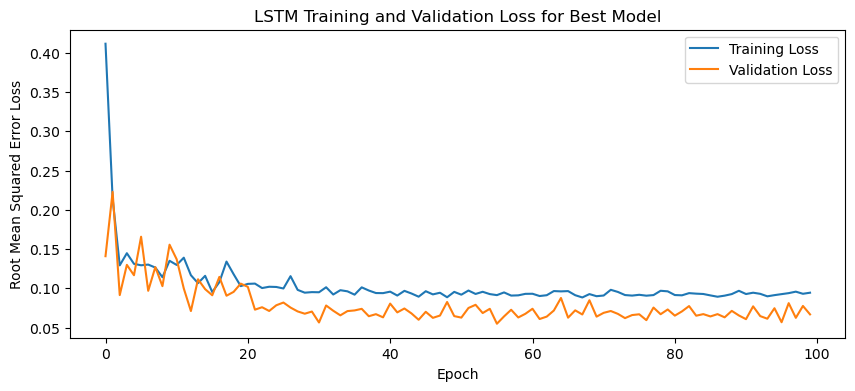

1/1 - 2s - loss: 0.0917 - 2s/epoch - 2s/step
Test Loss: 0.09173206984996796
Fold 3:
Epoch 1/100
19/19 [==============================] - 9s 126ms/step - loss: 0.3806 - val_loss: 0.1197
Epoch 2/100
19/19 [==============================] - 1s 33ms/step - loss: 0.1793 - val_loss: 0.1370
Epoch 3/100
19/19 [==============================] - 1s 31ms/step - loss: 0.1541 - val_loss: 0.1241
Epoch 4/100
19/19 [==============================] - 1s 33ms/step - loss: 0.1377 - val_loss: 0.1386
Epoch 5/100
19/19 [==============================] - 1s 31ms/step - loss: 0.1548 - val_loss: 0.0883
Epoch 6/100
19/19 [==============================] - 1s 32ms/step - loss: 0.1286 - val_loss: 0.1124
Epoch 7/100
19/19 [==============================] - 1s 36ms/step - loss: 0.1411 - val_loss: 0.1391
Epoch 8/100
19/19 [==============================] - 1s 37ms/step - loss: 0.1563 - val_loss: 0.1959
Epoch 9/100
19/19 [==============================] - 1s 33ms/step - loss: 0.1603 - val_loss: 0.0680
Epoch 10/100
19

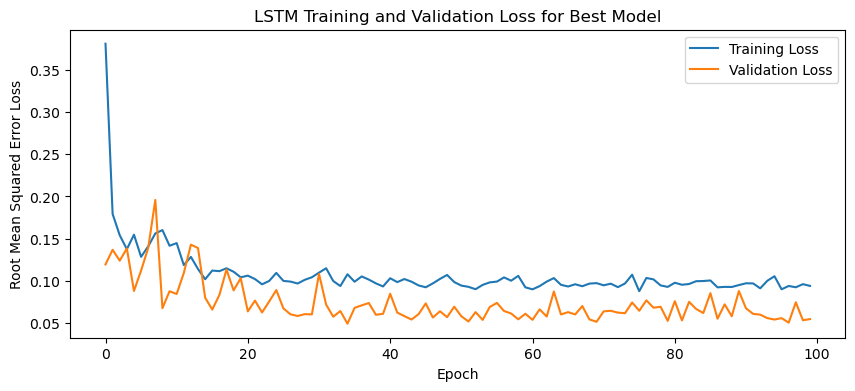

1/1 - 2s - loss: 0.0961 - 2s/epoch - 2s/step
Test Loss: 0.09607106447219849
Fold 4:
Epoch 1/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1135 - val_loss: 0.1487
Epoch 83/100
20/20 [==============================] - 1s 32ms/step - loss: 0.1173 - val_loss: 0.1902
Epoch 84/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1071 - val_loss: 0.1797
Epoch 85/100
20/20 [==============================] - 1s 43ms/step - loss: 0.1144 - val_loss: 0.1582
Epoch 86/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1024 - val_loss: 0.1733
Epoch 87/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1160 - val_loss: 0.1402
Epoch 88/100
20/20 [==============================] - 1s 45ms/step - loss: 0.1239 - val_loss: 0.1619
Epoch 89/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1171 - val_loss: 0.1730
Epoch 90/100
20/20 [==============================] - 1s 48ms/step - loss: 0.1216 - val_loss: 0.2512
Epoch 91

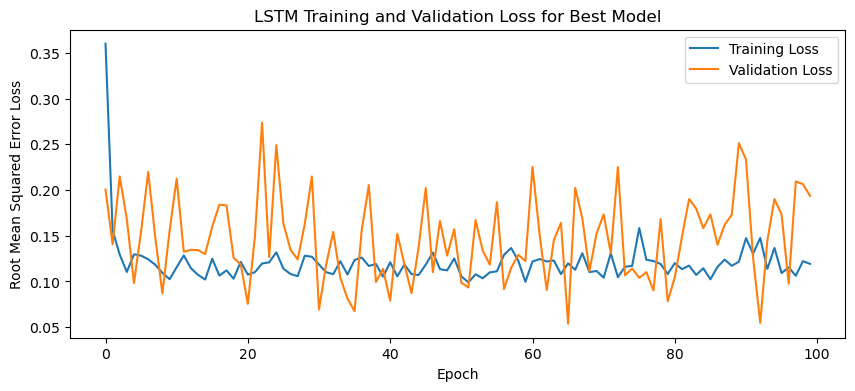

1/1 - 2s - loss: 0.0803 - 2s/epoch - 2s/step
Test Loss: 0.0802759975194931
Fold 5:
Epoch 1/100
19/19 [==============================] - 10s 108ms/step - loss: 0.3286 - val_loss: 0.1369
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1773 - val_loss: 0.1693
Epoch 3/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1472 - val_loss: 0.1683
Epoch 4/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1275 - val_loss: 0.1293
Epoch 5/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1488 - val_loss: 0.1665
Epoch 6/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1248 - val_loss: 0.2420
Epoch 7/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1221 - val_loss: 0.1168
Epoch 8/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1238 - val_loss: 0.1692
Epoch 9/100
19/19 [==============================] - 0s 24ms/step - loss: 0.1297 - val_loss: 0.2456
Epoch 10/100
19

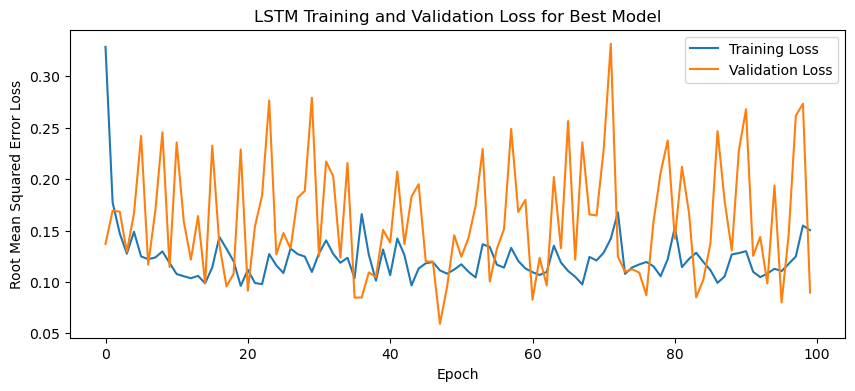

1/1 - 3s - loss: 0.1001 - 3s/epoch - 3s/step
Test Loss: 0.10011575371026993


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

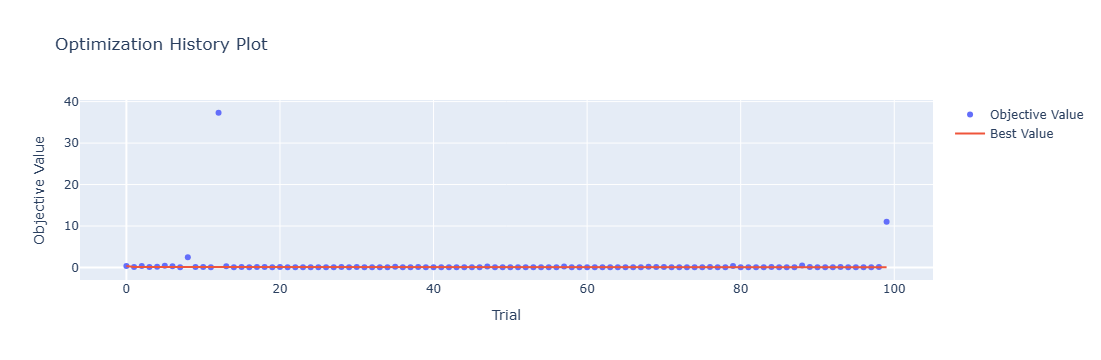

In [4]:
optuna.visualization.plot_optimization_history(study)

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

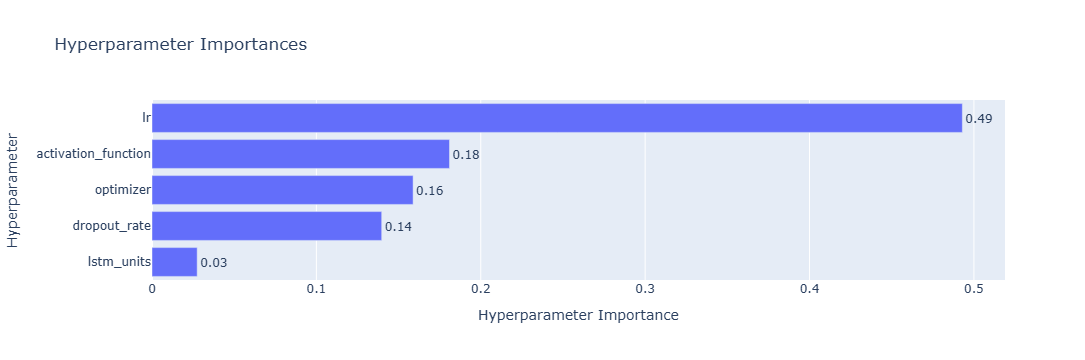

In [6]:
optuna.visualization.plot_param_importances(study)

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 7s 92ms/step - loss: 0.4373 - accuracy: 0.2632 - mae: 0.3893 - rmse: 0.4373 - mape: 70.8419 - pearson: 0.3002 - val_loss: 0.0920 - val_accuracy: 0.0000e+00 - val_mae: 0.0740 - val_rmse: 0.0920 - val_mape: 12.8975 - val_pearson: 0.5210
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.2242 - accuracy: 0.2632 - mae: 0.1953 - rmse: 0.2242 - mape: 36.2307 - pearson: 0.3725 - val_loss: 0.1626 - val_accuracy: 0.3333 - val_mae: 0.1450 - val_rmse: 0.1626 - val_mape: 28.0389 - val_pearson: 0.5109
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1249 - accura

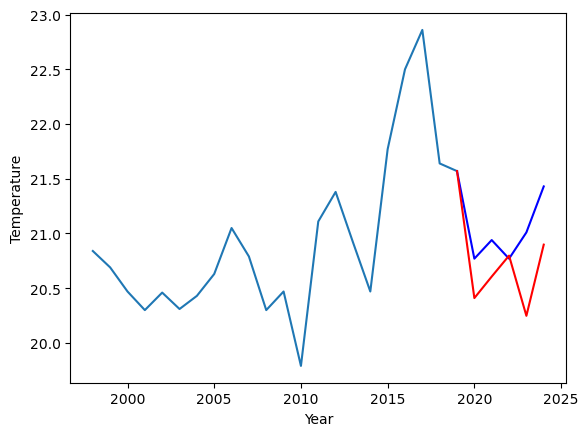

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		16.14		-1.38
16.69		16.34		-0.35
16.18		16.53		0.35
16.46		15.98		-0.48
16.29		16.63		0.34


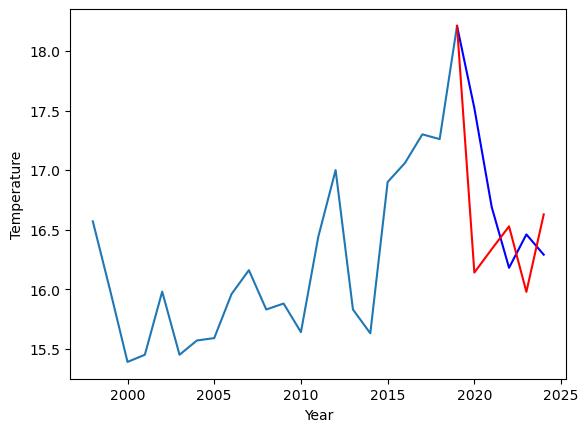

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  20.410028
1                1   17.52  16.140028


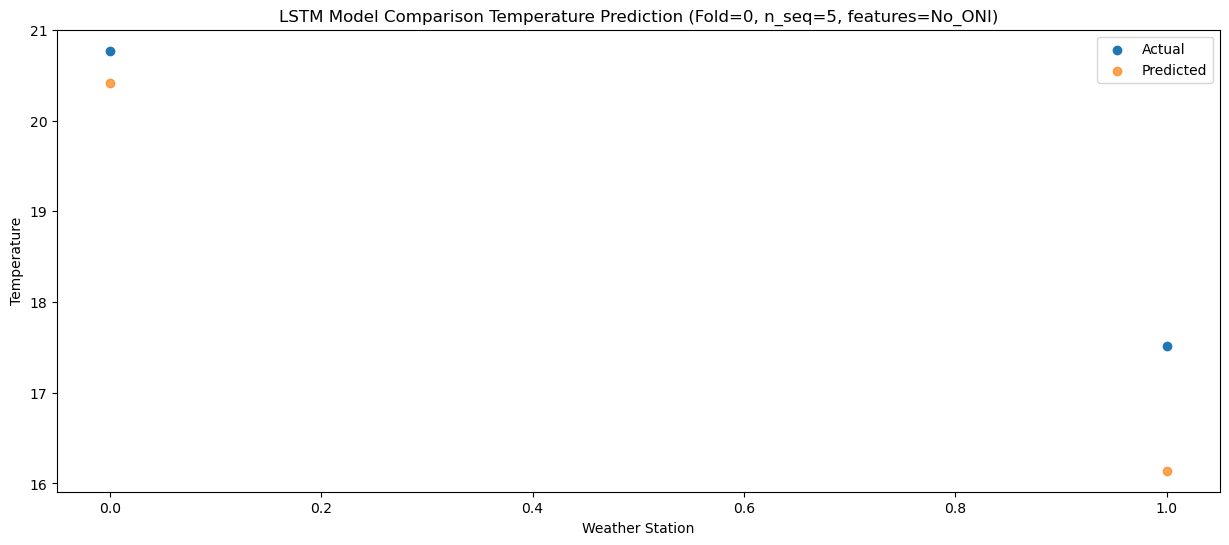

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  20.606325
1                1   16.69  16.336326


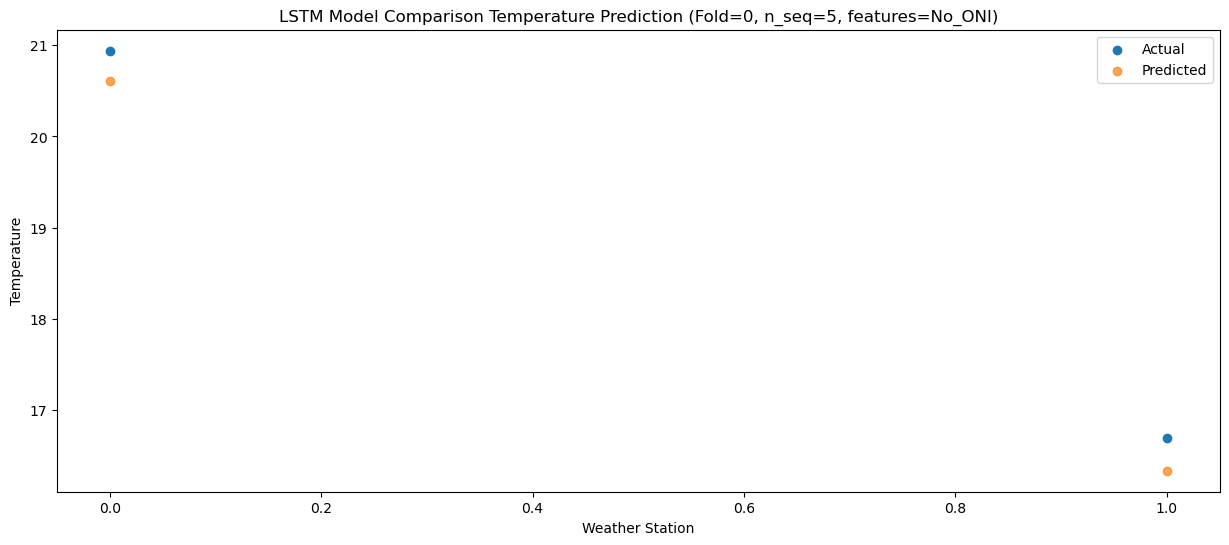

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77    20.7977
1                1   16.18    16.5277


Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  20.247861
1                1   16.46  15.977862


Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  20.898128
1                1   16.29  16.628129


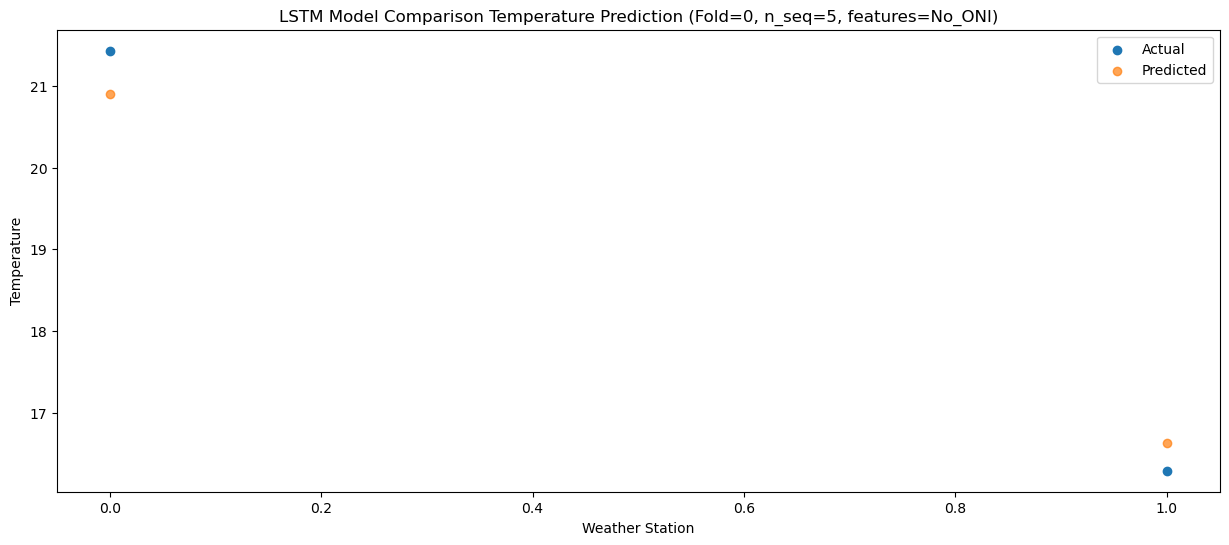

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[20.41002756 16.14002792]
 [20.60632546 16.33632619]
 [20.79769955 16.52770028]
 [20.24786101 15.97786174]
 [20.89812784 16.62812857]]
Year at t+1:
t+1 SKRMSE: 1.008440
t+1 KRMSE: 1.008440
t+1 MAE: 0.869972
t+1 SKMAPE: 0.048048
t+1 R2_SCORE: 0.614882
t+1 KMAPE: 0.048048
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.343820
t+2 KRMSE: 0.343820
t+2 MAE: 0.343674
t+2 SKMAPE: 0.018563
t+2 R2_SCORE: 0.973822
t+2 KMAPE: 0.018563
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.246640
t+3 KRMSE: 0.246640
t+3 MAE: 0.187700
t+3 SKMAPE: 0.011412
t+3 R2_SCORE: 0.988451
t+3 KMAPE: 0.011412
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.637696
t+4 KRMSE: 0.637696
t+4 MAE: 0.622139
t+4 SKMAPE: 0.032783
t+4 R2_SCORE: 0.921429
t+4 KMAPE: 0.032783
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.445656
t+5 KRMSE: 0.445656
t+5 MAE: 0.435000
t+5 SKMAPE: 0.022788
t+5 R2_SCORE: 0.969930
t+5 KMAPE: 0.022788
t+5 PEARSON: 1

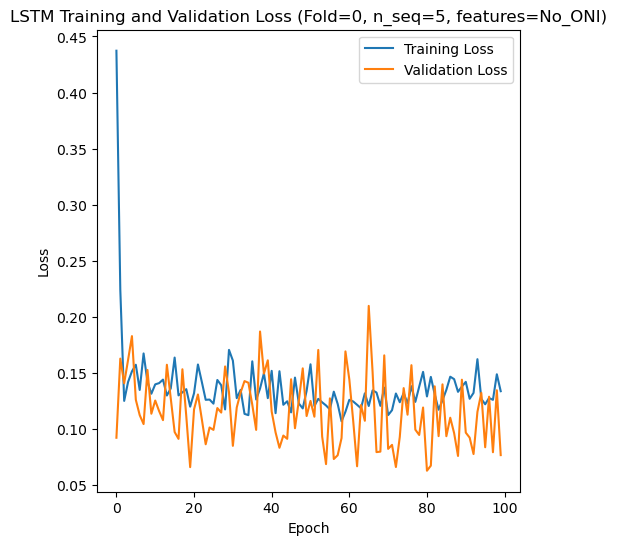

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 5s 77ms/step - loss: 0.3679 - accuracy: 0.3684 - mae: 0.3199 - rmse: 0.3679 - mape: 52.7971 - pearson: 0.3533 - val_loss: 0.1811 - val_accuracy: 0.0000e+00 - val_mae: 0.1574 - val_rmse: 0.1811 - val_mape: 23.9741 - val_pearson: 0.2562
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.2013 - accuracy: 0.3158 - mae: 0.1743 - rmse: 0.2013 - mape: 29.3011 - pearson: 0.3565 - val_loss: 0.1217 - val_accuracy: 0.0000e+00 - val_mae: 0.0977 - val_rmse: 0.1217 - val_mape: 15.4903 - val_pearson: 0.5493
Epoch 3/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1471 - acc

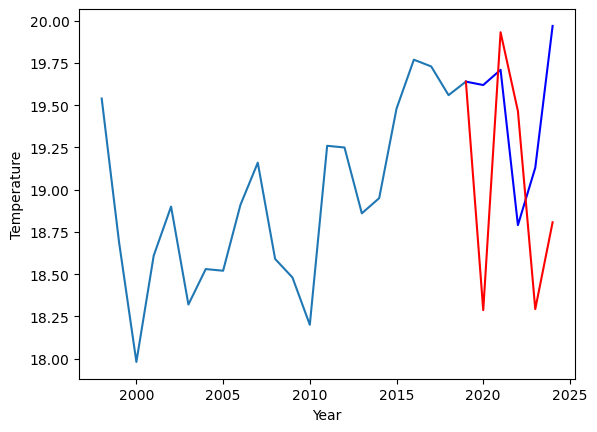

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		18.44		-1.38
20.34		20.08		-0.26
19.95		19.62		-0.33
19.95		18.44		-1.51
21.26		18.96		-2.30


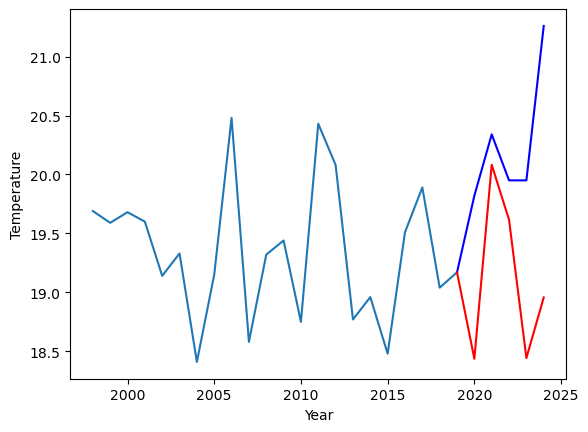

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  18.286696
1                1   19.82  18.436696


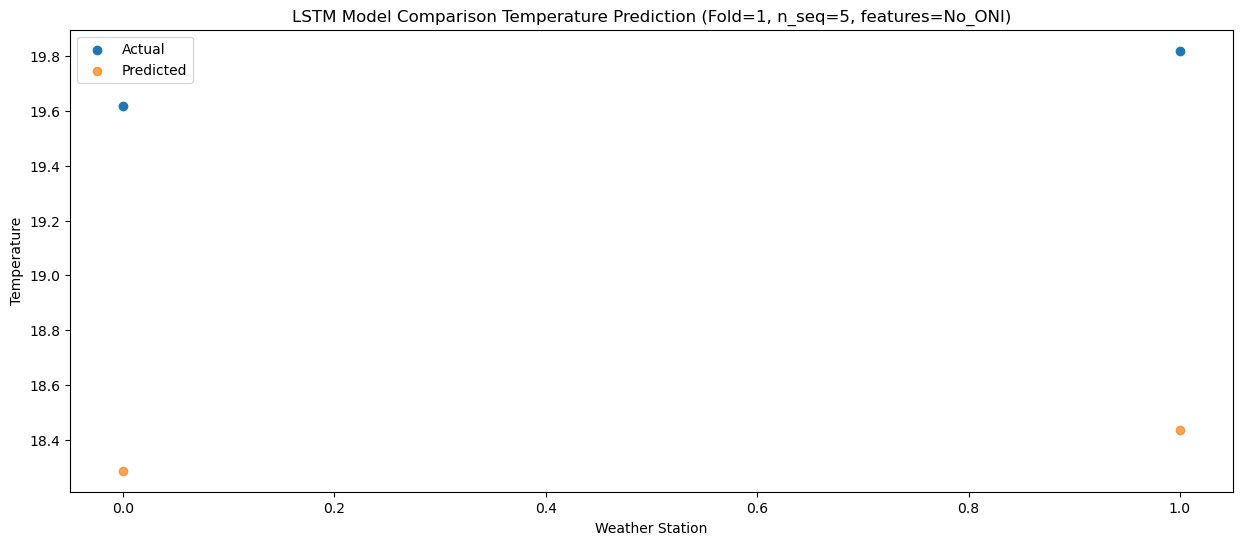

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  19.932464
1                1   20.34  20.082463


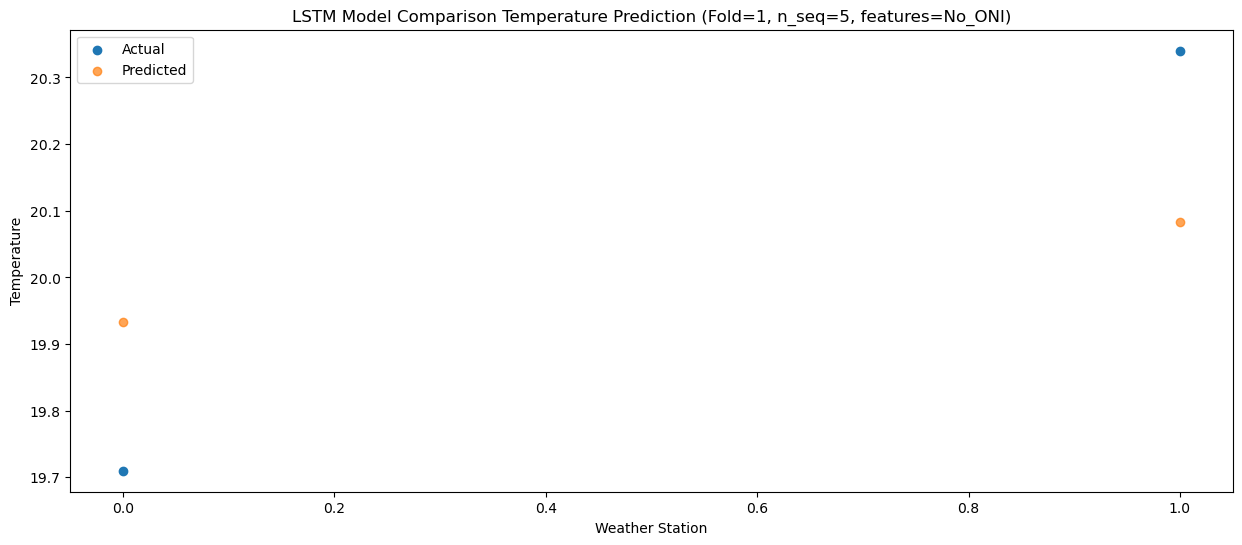

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  19.465237
1                1   19.95  19.615238


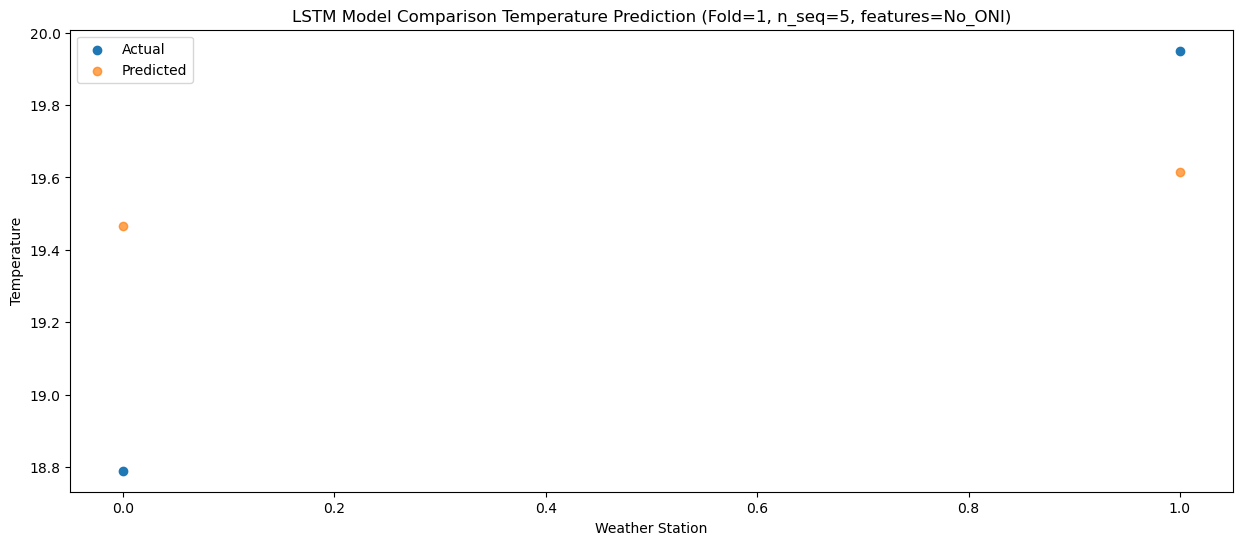

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  18.292704
1                1   19.95  18.442705


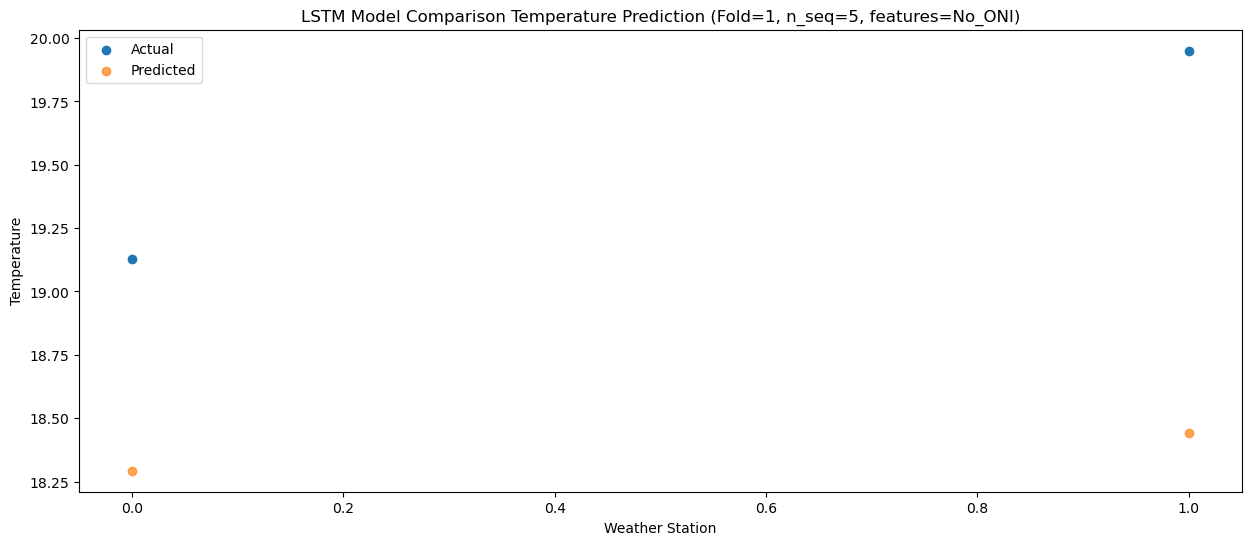

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  18.807071
1                1   21.26  18.957072


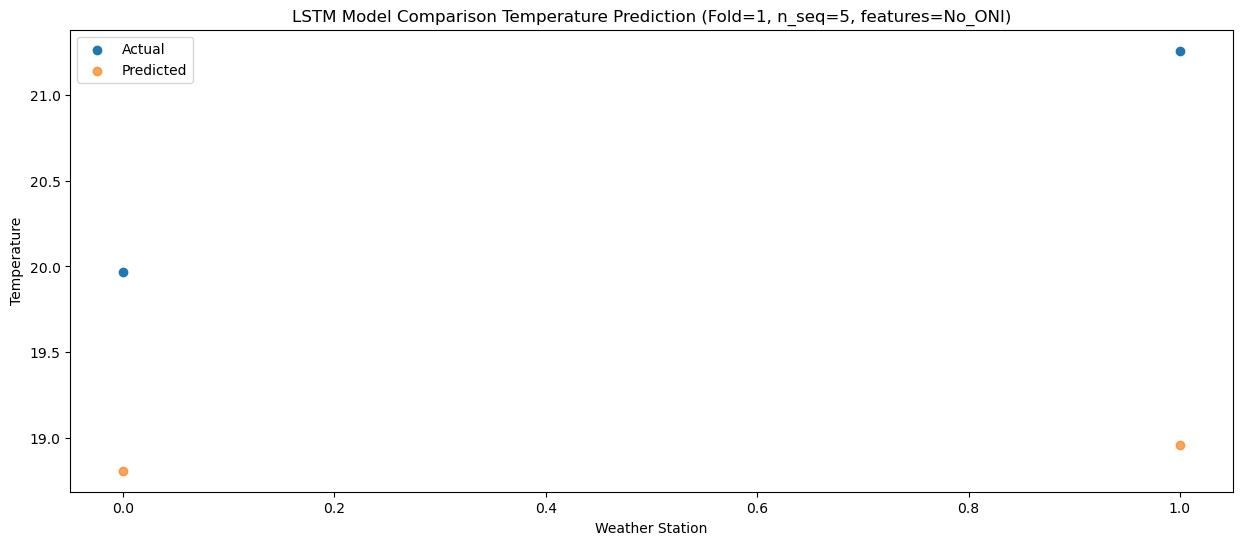

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[18.286696   18.43669552]
 [19.93246356 20.08246309]
 [19.46523736 19.61523813]
 [18.29270373 18.44270486]
 [18.80707137 18.95707208]]
Year at t+1:
t+1 SKRMSE: 1.358534
t+1 KRMSE: 1.358534
t+1 MAE: 1.358304
t+1 SKMAPE: 0.068875
t+1 R2_SCORE: -183.561543
t+1 KMAPE: 0.068875
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.240640
t+2 KRMSE: 0.240640
t+2 MAE: 0.240000
t+2 SKMAPE: 0.011974
t+2 R2_SCORE: 0.416401
t+2 KMAPE: 0.011974
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.532922
t+3 KRMSE: 0.532922
t+3 MAE: 0.505000
t+3 SKMAPE: 0.026358
t+3 R2_SCORE: 0.155751
t+3 KMAPE: 0.026358
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.219222
t+4 KRMSE: 1.219222
t+4 MAE: 1.172296
t+4 SKMAPE: 0.059661
t+4 R2_SCORE: -7.842962
t+4 KMAPE: 0.059661
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.824264
t+5 KRMSE: 1.824264
t+5 MAE: 1.732928
t+5 SKMAPE: 0.083278
t+5 R2_SCORE: -6.999375
t+5 KMAPE: 0.083278
t+5 PEARS

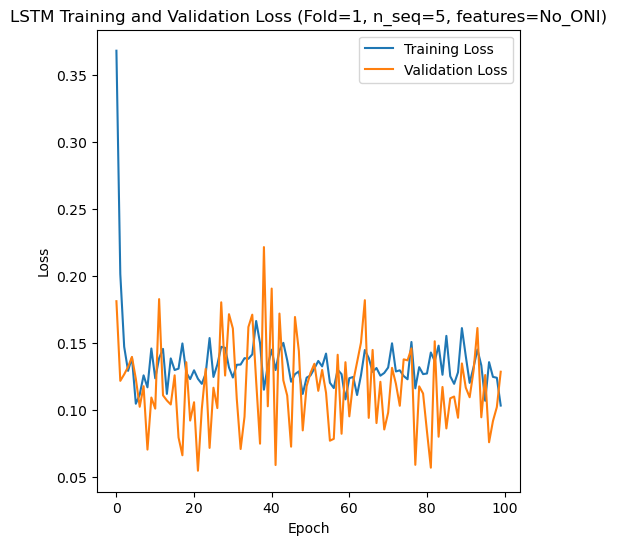

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 5s 79ms/step - loss: 0.3639 - accuracy: 0.2632 - mae: 0.3058 - rmse: 0.3639 - mape: 54.1829 - pearson: 0.3116 - val_loss: 0.0617 - val_accuracy: 0.6667 - val_mae: 0.0491 - val_rmse: 0.0617 - val_mape: 8.3316 - val_pearson: 0.4989
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1728 - accuracy: 0.4737 - mae: 0.1500 - rmse: 0.1728 - mape: 24.6037 - pearson: 0.3326 - val_loss: 0.0916 - val_accuracy: 0.3333 - val_mae: 0.0748 - val_rmse: 0.0916 - val_mape: 11.8272 - val_pearson: 0.2936
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 0.1584 - accuracy: 0.

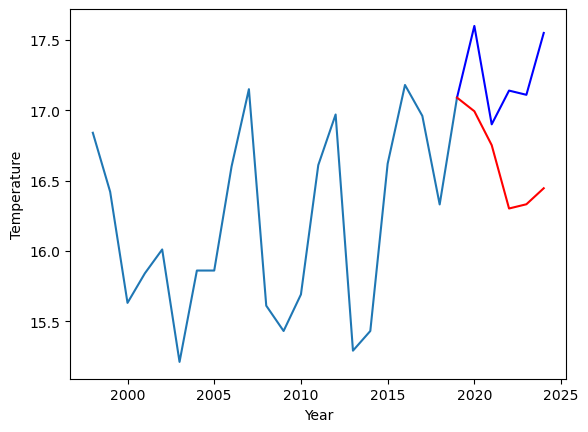

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		13.66		-0.18
13.83		13.42		-0.41
13.82		12.97		-0.85
13.36		13.00		-0.36
14.15		13.12		-1.03


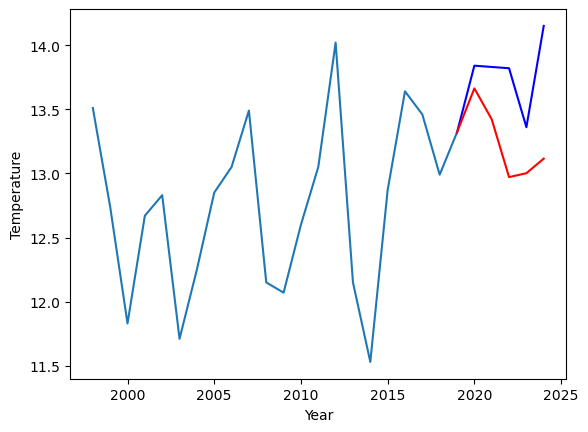

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  16.993055
1                1   13.84  13.663056


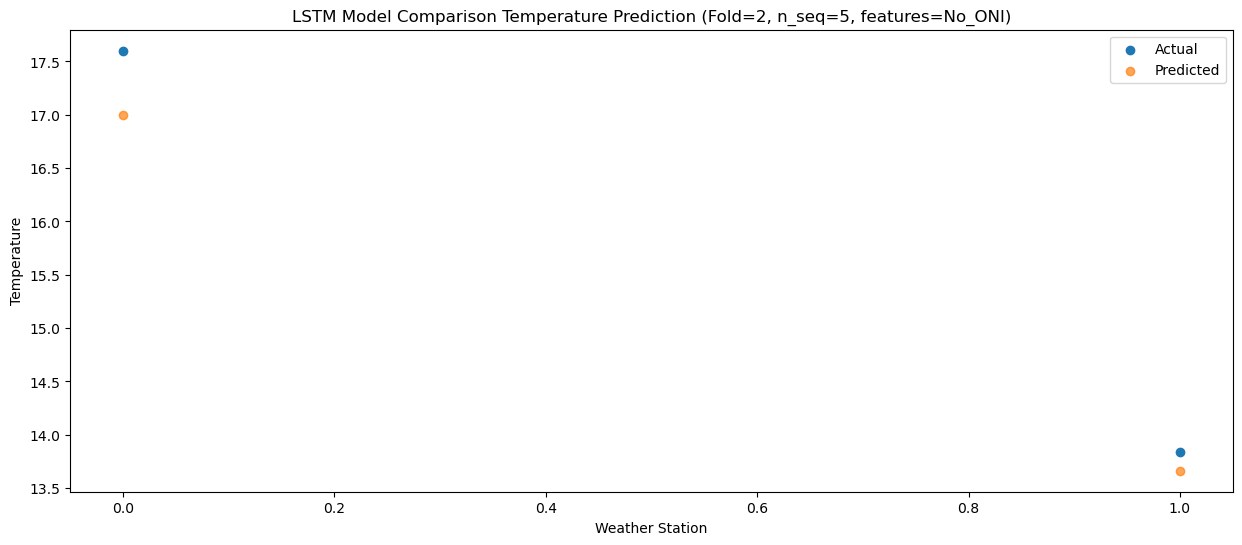

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  16.751925
1                1   13.83  13.421926


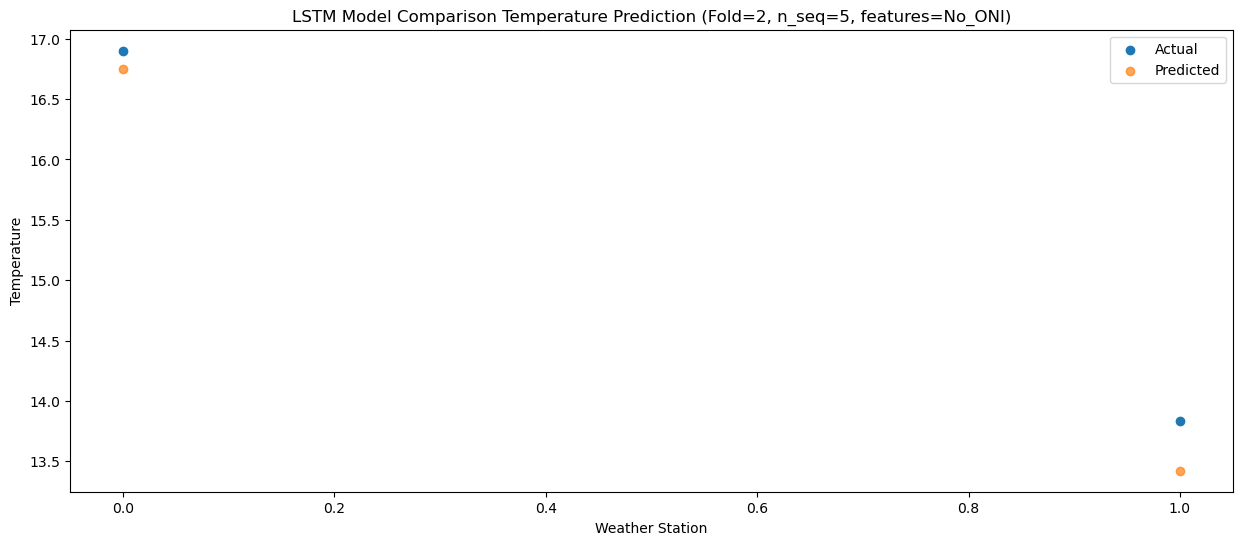

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  16.301318
1                1   13.82  12.971318


Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  16.331458
1                1   13.36  13.001458


Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  16.445369
1                1   14.15  13.115370


f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[16.99305455 13.6630558 ]
 [16.75192451 13.42192576]
 [16.30131808 12.97131808]
 [16.33145765 13.00145849]
 [16.44536868 13.11536952]]
Year at t+1:
t+1 SKRMSE: 0.447041
t+1 KRMSE: 0.447041
t+1 MAE: 0.391945
t+1 SKMAPE: 0.023635
t+1 R2_SCORE: 0.943457
t+1 KMAPE: 0.023635
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.306962
t+2 KRMSE: 0.306962
t+2 MAE: 0.278075
t+2 SKMAPE: 0.019134
t+2 R2_SCORE: 0.960010
t+2 KMAPE: 0.019134
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.843697
t+3 KRMSE: 0.843697
t+3 MAE: 0.843682
t+3 SKMAPE: 0.055170
t+3 R2_SCORE: 0.741681
t+3 KMAPE: 0.055170
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.606086
t+4 KRMSE: 0.606086
t+4 MAE: 0.568542
t+4 SKMAPE: 0.036170
t+4 R2_SCORE: 0.895512
t+4 KMAPE: 0.036170
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.070203
t+5 KRMSE: 1.070203
t+5 MAE: 1.069631
t+5 SKMAPE: 0.068030
t+5 R2_SCORE: 0.603690
t+5 KMAPE: 0.068030
t+5 PEARSON: 1

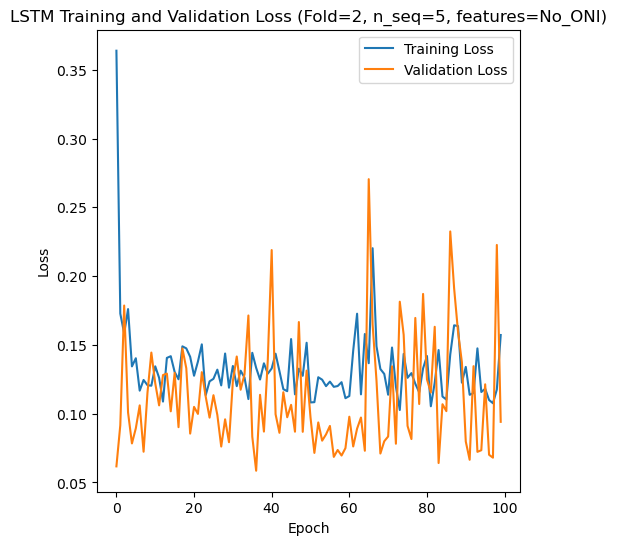

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 6s 80ms/step - loss: 0.3616 - accuracy: 0.1500 - mae: 0.3203 - rmse: 0.3616 - mape: 49.0727 - pearson: 0.2102 - val_loss: 0.1735 - val_accuracy: 0.5000 - val_mae: 0.1341 - val_rmse: 0.1735 - val_mape: 22.0036 - val_pearson: 0.2805
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.1592 - accuracy: 0.2000 - mae: 0.1332 - rmse: 0.1592 - mape: 21.1127 - pearson: 0.3015 - val_loss: 0.1606 - val_accuracy: 0.5000 - val_mae: 0.1477 - val_rmse: 0.1606 - val_mape: 23.6330 - val_pearson: 0.7164
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1715 - accuracy: 0.

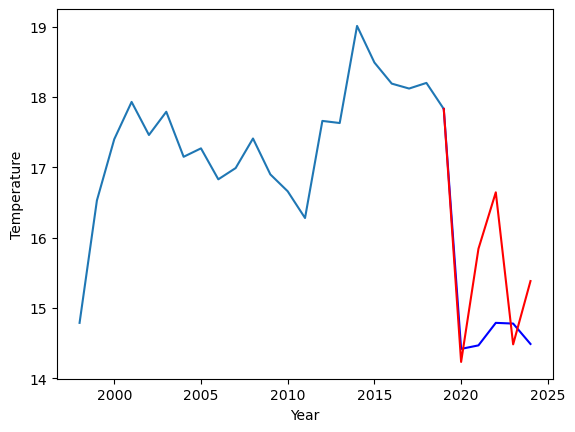

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		13.50		-0.97
14.35		15.11		0.76
14.15		15.92		1.77
13.85		13.75		-0.10
14.87		14.65		-0.22


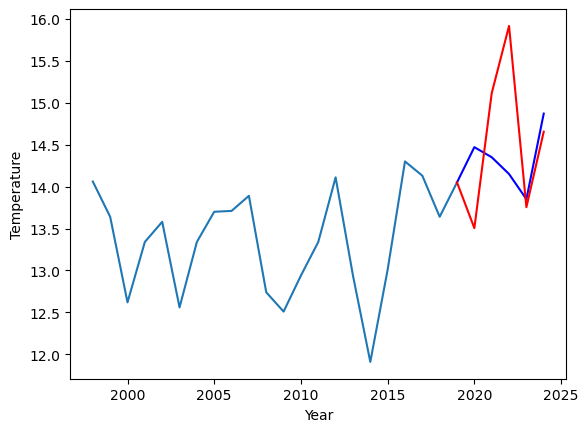

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.234846
1                1   14.47  13.504846


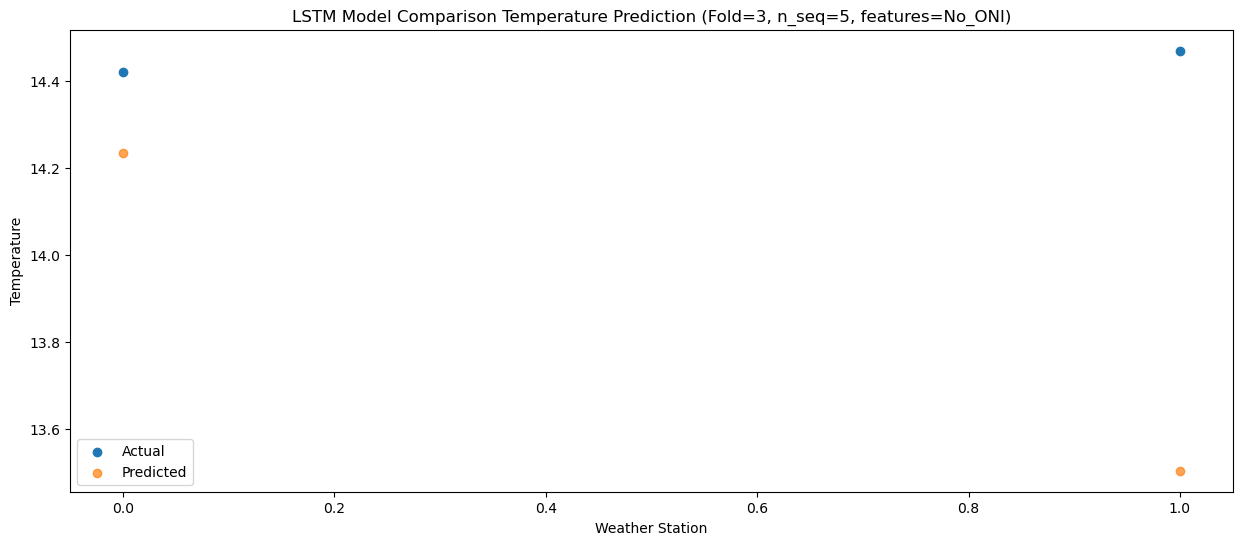

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.842852
1                1   14.35  15.112852


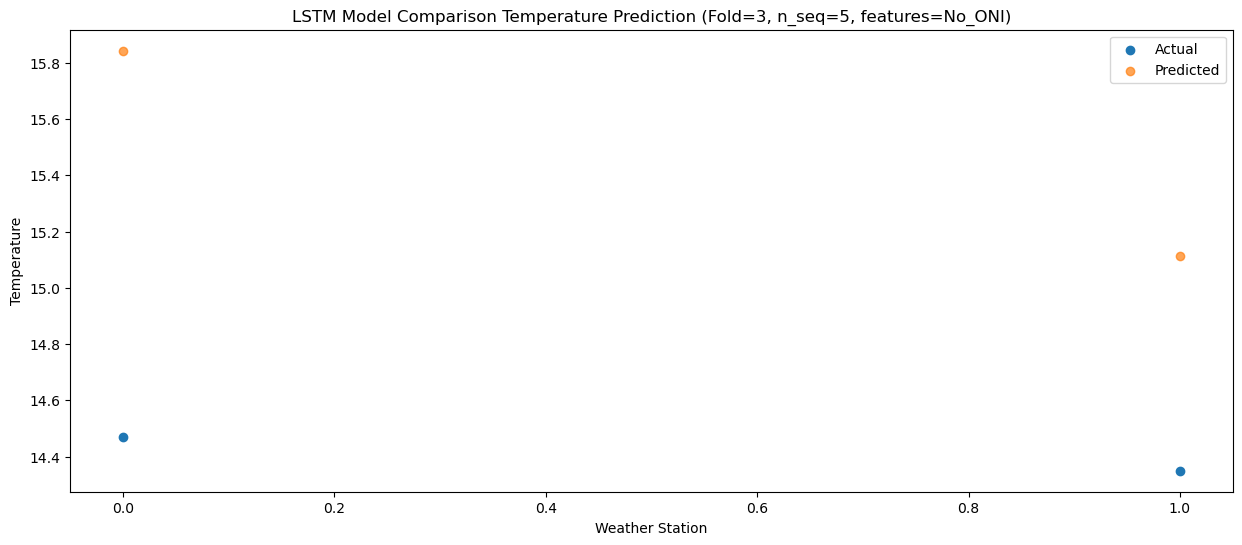

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  16.645203
1                1   14.15  15.915204


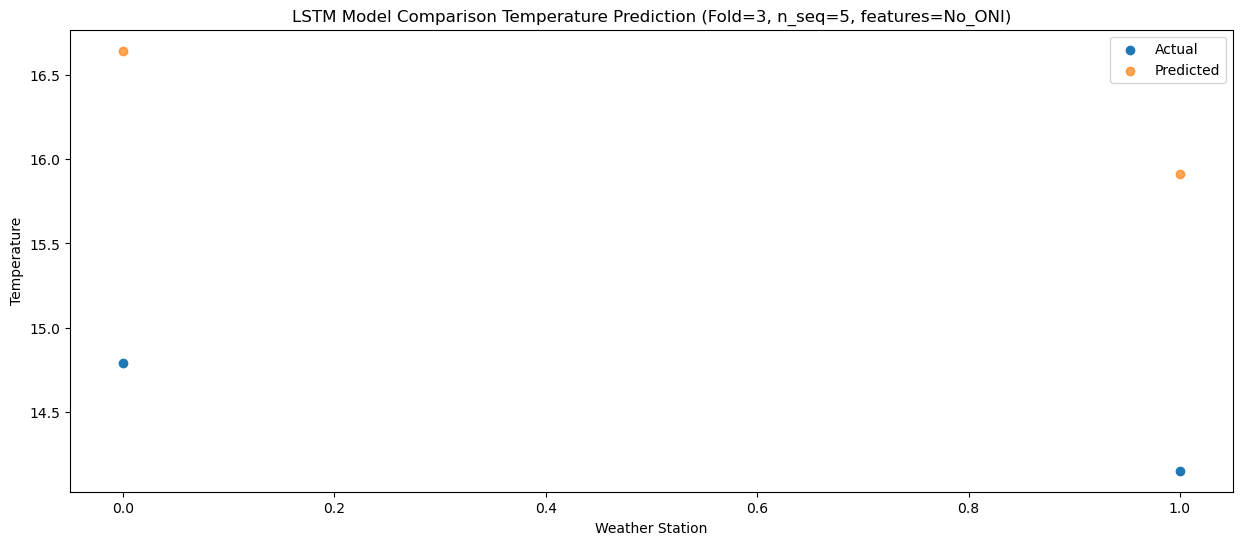

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  14.484261
1                1   13.85  13.754262


Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  15.383861
1                1   14.87  14.653862


f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.23484586 13.50484621]
 [15.84285221 15.11285209]
 [16.64520285 15.91520357]
 [14.48426125 13.75426173]
 [15.38386116 14.65386164]]
Year at t+1:
t+1 SKRMSE: 0.694911
t+1 KRMSE: 0.694911
t+1 MAE: 0.575154
t+1 SKMAPE: 0.039770
t+1 R2_SCORE: -771.643112
t+1 KMAPE: 0.039770
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.110555
t+2 KRMSE: 1.110555
t+2 MAE: 1.067852
t+2 SKMAPE: 0.074018
t+2 R2_SCORE: -341.592572
t+2 KMAPE: 0.074018
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.810762
t+3 KRMSE: 1.810762
t+3 MAE: 1.810203
t+3 SKMAPE: 0.125093
t+3 R2_SCORE: -31.020123
t+3 KMAPE: 0.125093
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.219804
t+4 KRMSE: 0.219804
t+4 MAE: 0.195739
t+4 SKMAPE: 0.013461
t+4 R2_SCORE: 0.776559
t+4 KMAPE: 0.013461
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.650271
t+5 KRMSE: 0.650271
t+5 MAE: 0.555000
t+5 SKMAPE: 0.038112
t+5 R2_SCORE: -10.713346
t+5 KMAPE: 0.038112
t+5 

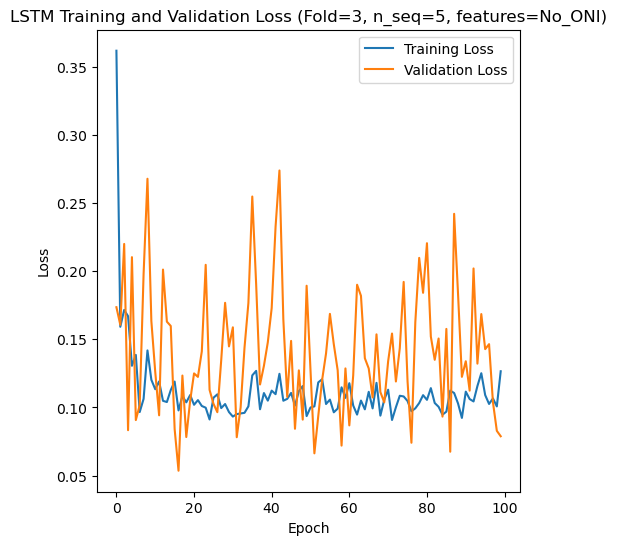

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 6s 86ms/step - loss: 0.3621 - accuracy: 0.2632 - mae: 0.2981 - rmse: 0.3621 - mape: 46.3465 - pearson: 0.2910 - val_loss: 0.3412 - val_accuracy: 0.0000e+00 - val_mae: 0.2949 - val_rmse: 0.3412 - val_mape: 57.3035 - val_pearson: 0.8868
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.1865 - accuracy: 0.2632 - mae: 0.1624 - rmse: 0.1865 - mape: 26.0536 - pearson: 0.3949 - val_loss: 0.2109 - val_accuracy: 0.0000e+00 - val_mae: 0.1983 - val_rmse: 0.2109 - val_mape: 36.8569 - val_pearson: 0.1712
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.1452 - ac

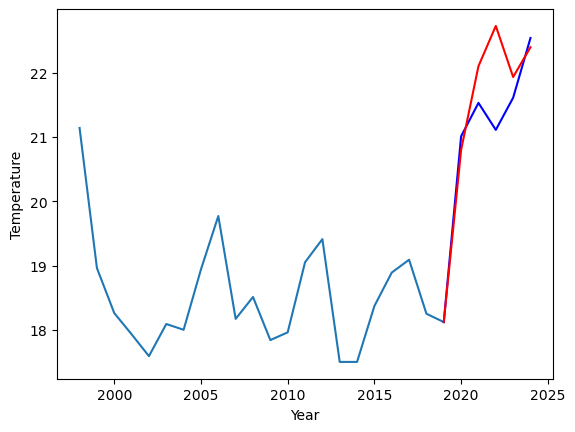

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		12.59		0.36
12.79		13.89		1.10
13.11		14.52		1.41
12.24		13.72		1.48
13.72		14.19		0.47


Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  20.799721
1                1   12.23  12.589722


Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  22.100924
1                1   12.79  13.890925


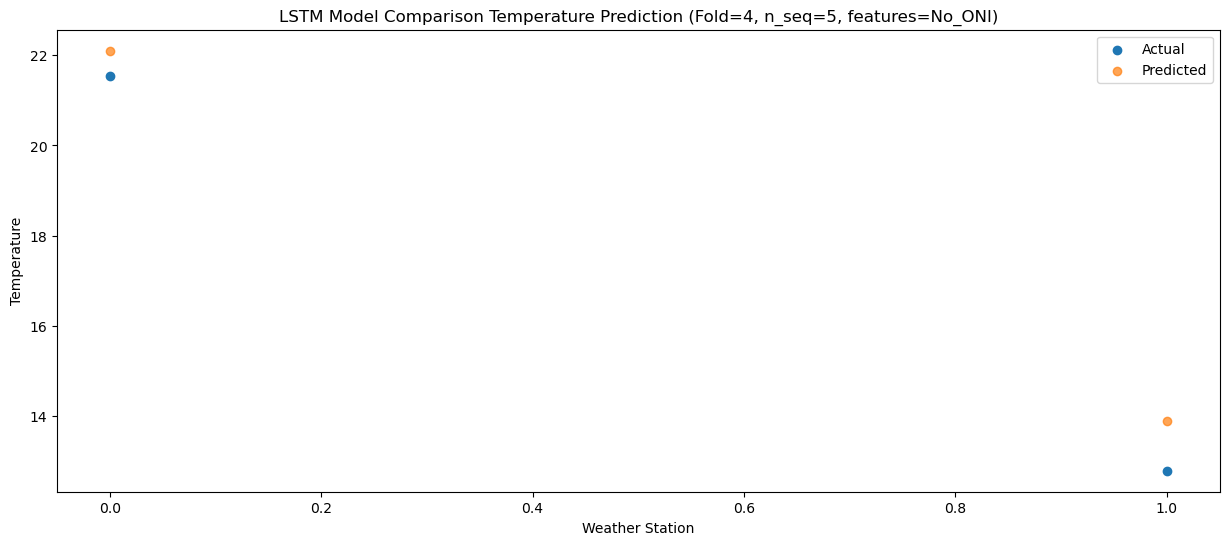

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  22.727364
1                1   13.11  14.517363


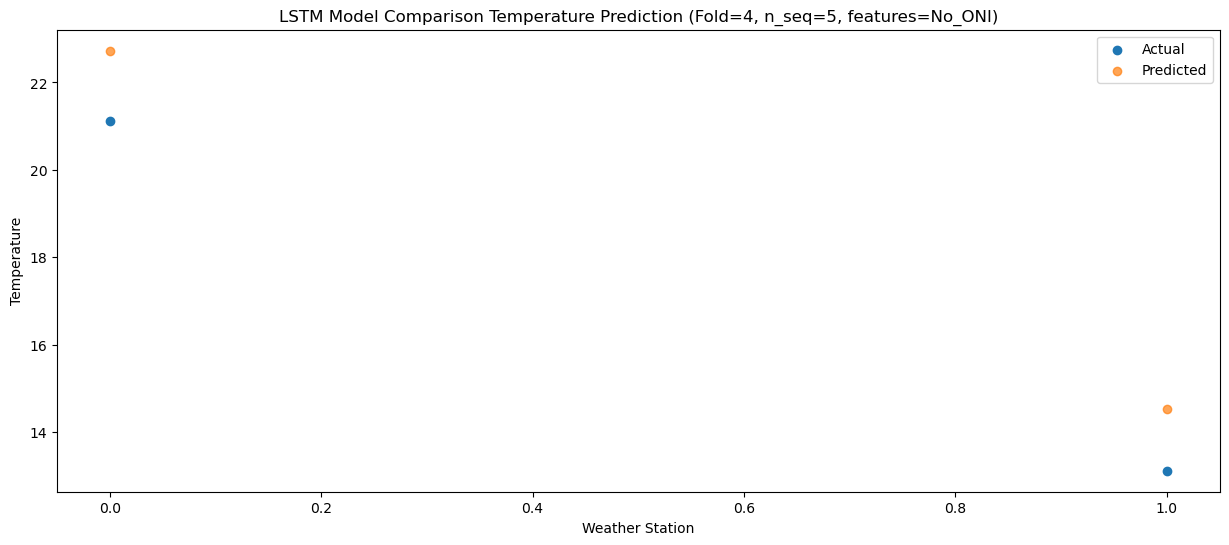

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  21.932629
1                1   12.24  13.722629


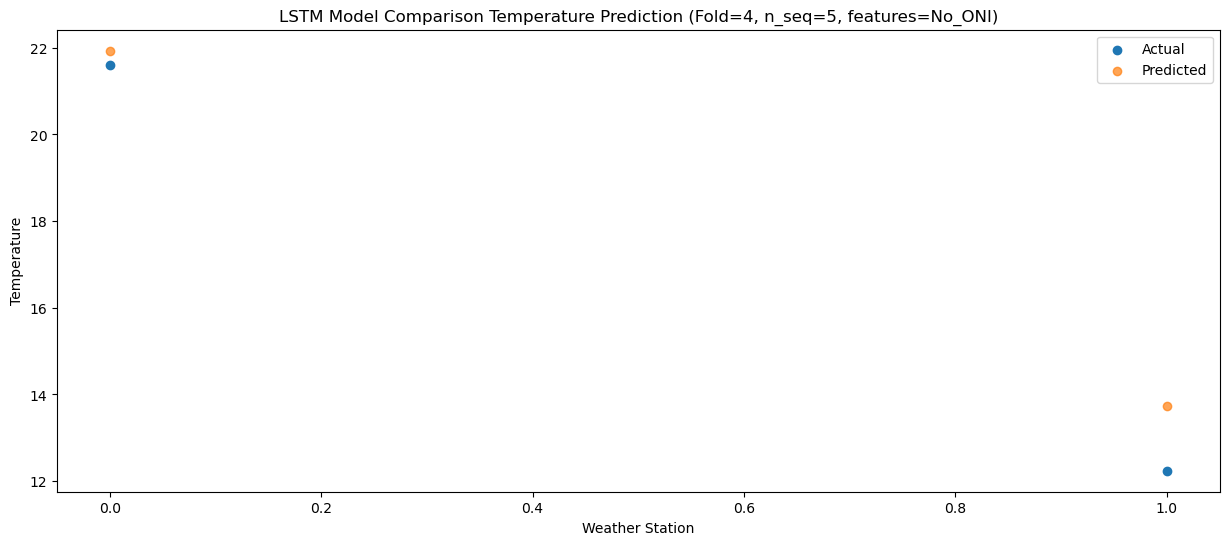

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  22.396017
1                1   13.72  14.186018


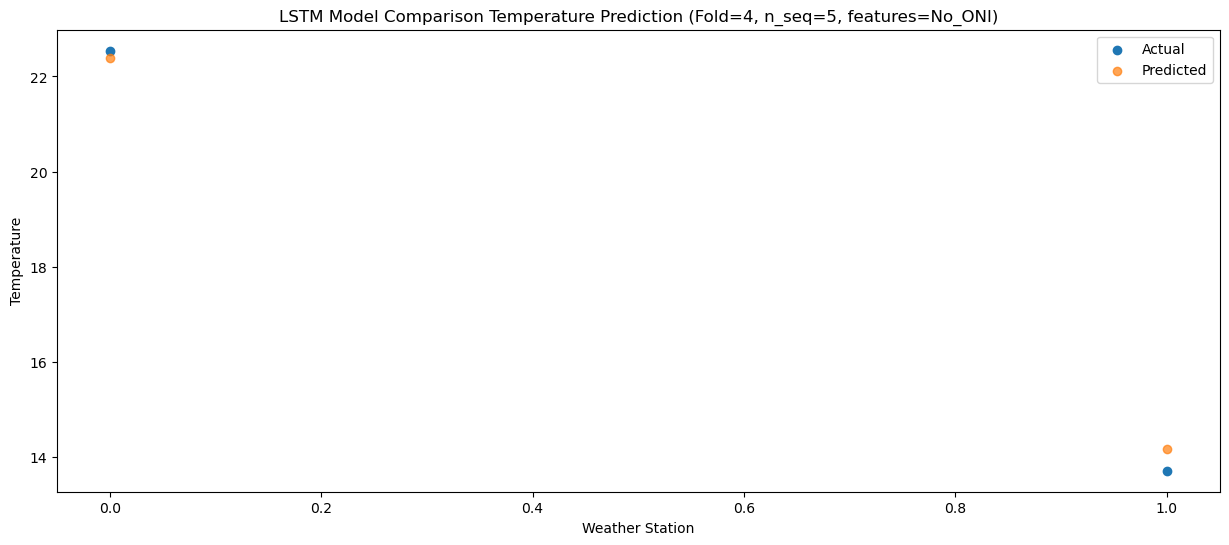

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[20.79972126 12.58972209]
 [22.10092427 13.89092474]
 [22.72736354 14.51736318]
 [21.932629   13.72262865]
 [22.39601697 14.18601828]]
Year at t+1:
t+1 SKRMSE: 0.294633
t+1 KRMSE: 0.294633
t+1 MAE: 0.285000
t+1 SKMAPE: 0.019711
t+1 R2_SCORE: 0.995496
t+1 KMAPE: 0.019711
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.876924
t+2 KRMSE: 0.876924
t+2 MAE: 0.835925
t+2 SKMAPE: 0.056297
t+2 R2_SCORE: 0.959732
t+2 KMAPE: 0.056297
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.516004
t+3 KRMSE: 1.516004
t+3 MAE: 1.512363
t+3 SKMAPE: 0.091983
t+3 R2_SCORE: 0.856358
t+3 KMAPE: 0.091983
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.072911
t+4 KRMSE: 1.072911
t+4 MAE: 0.902629
t+4 SKMAPE: 0.068030
t+4 R2_SCORE: 0.947554
t+4 KMAPE: 0.068030
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.344894
t+5 KRMSE: 0.344894
t+5 MAE: 0.305001
t+5 SKMAPE: 0.020177
t+5 R2_SCORE: 0.993884
t+5 KMAPE: 0.020177
t+5 PEARSON: 1

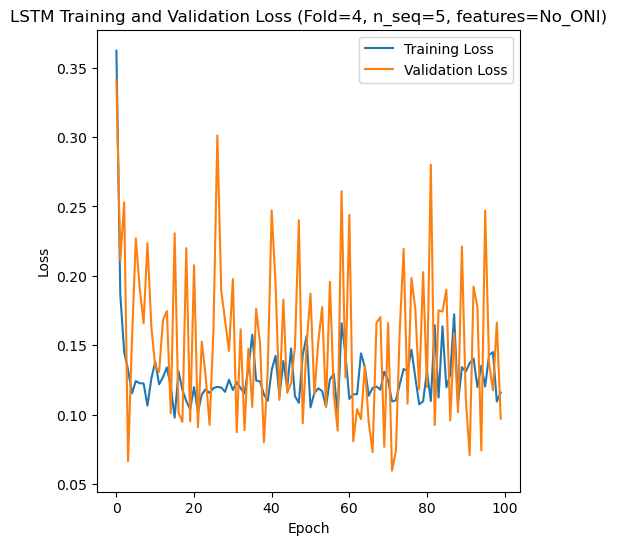

[[0.6002101124667358], [1.1833824762299696], [0.7097282664400967], [1.0455870345191418], [0.9406553155307409]]
[[array(0.60021011)], [array(1.18338248)], [array(0.70972827)], [array(1.04558703)], [array(0.94065532)]]
[[0.49169706904888066], [1.001705615520478], [0.6303748875111351], [0.8407895202636719], [0.7681835532188421]]
[[0.02671880249666203], [0.05002924919890546], [0.04042796352901813], [0.058090750836636694], [0.05123961974747617]]
[[0.926287554937214], [-2.5204887201299475], [0.8354638657276479], [-11.679210506987998], [0.9544146809313965]]
[[array(0.0267188)], [array(0.05002925)], [array(0.04042796)], [array(0.05809075)], [array(0.05123962)]]
[[array(0.95122054)], [array(0.01566531)], [array(0.96562124)], [array(0.06887482)], [array(0.9817045)]]
[[[20.41002755999565, 20.60632545888424, 20.797699552178383, 20.24786100924015, 20.898127835392952], [16.14002791762352, 16.336326189041138, 16.52770028233528, 15.97786173939705, 16.62812856554985]], [[18.28669599533081, 19.932463564

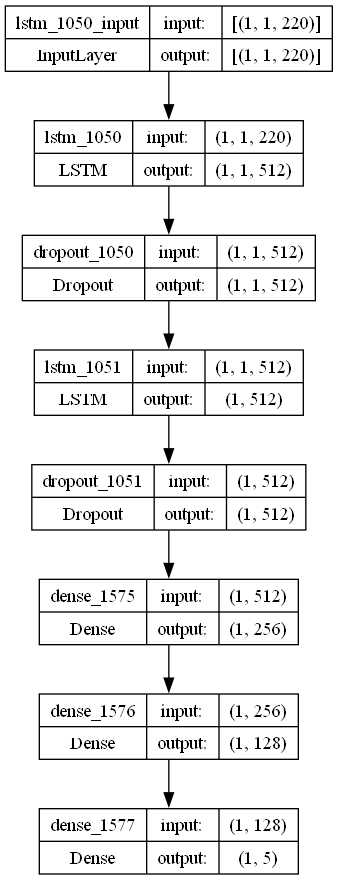

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.008707498599127594
    optimizer = Adam(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 512
    dropout_rate = 0.2973306421204898

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S5_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)